In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
from lib import evaluations
import matplotlib.pyplot as plt
import numpy as np
from lib import utility 

In [3]:
t= np.ones(64)*10
s= np.ones(64)*4

np.max((t,s))

10.0

In [4]:
def plot_kf_traj(pred, actual, sigma, start=0):
    timesteps = len(actual)
    print(timesteps)

    def color(i):
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
        return colors[i % len(colors)]

    state_dim = actual.shape[-1]
    
    x_max = pred[start:, 0] +sigma[start:, 0,0]
    y_max = pred[start, 0] + sigma[start:, 0,0]
    
    vmax = np.max((x_max, y_max)) + 0.5
    
    x_min = pred[start:, 0]  -sigma[start:, 1,1]
    y_min = pred[start, 0] - sigma[start:, 1,1]
    
    vmin = np.min((x_min, y_min)) - 0.5
    
    for j in range(state_dim):
        plt.figure(figsize=(8, 6))


        predicted_label_arg = {}
        actual_label_arg = {}

        predicted_label_arg['label'] = "Predicted"
        actual_label_arg['label'] = "Ground Truth"
        plt.plot(range(timesteps-start),
                 pred[start:, j],
#                      c=color(0),
                 **predicted_label_arg)
        plt.plot(range(timesteps-start),
                 actual[start:, j],
#                      c=color(1),
                 **actual_label_arg)

        conf_min = pred[start:, j] - np.sqrt(sigma[start:, j, j]) 
        conf_max = pred[start:, j] + np.sqrt(sigma[start:, j, j])
        plt.fill_between(range(timesteps-start), 
                         conf_min, conf_max, 
                         alpha=0.5)

        rmse = np.sqrt(np.mean(
        (pred[start:, j] - actual[start:, j]) ** 2))

        plt.title(f"State #{j} ")
        plt.xlabel("Timesteps")
        plt.ylabel("Value")
#             plt.legend()
#             plt.ylim(-2, 2)
        plt.ylim(vmin, vmax)
        plt.show()


In [5]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Ellipse

def draw_2d(ax, covariance, mean, color='g'):
    E, V = np.linalg.eig(covariance)

    angle = np.arctan2(V[0,0], V[0,1]) / np.pi * 180.0
    el = Ellipse(xy=mean, width=2*np.sqrt(E[1]*5.99), height=2*np.sqrt(E[0]*5.99), angle=angle,
                 color=color, alpha=0.1)
#     el = Ellipse(xy=mean, width=np.sqrt(E[1]*5.99), height=np.sqrt(E[0]*5.99), angle=angle,
#              color='g', alpha=0.1)
#     el = Ellipse(xy=mean, width=np.sqrt(E[1]*5.99), height=np.sqrt(E[0]*5.99), angle=angle,
#              color='g', alpha=0.1)
    ax.add_artist(el)
    


def eval_2d_rollout(predicted_states,  actual_states,  covariance, contact_states,
                    plot=True, plot_traj=None, start=0, actions=None, arrow=False ):
    contact = np.argmax(contact_states)
    print(contact)
    intervals = int((predicted_states.shape[0]-1 -contact)/4.0)
    print(intervals)
    plot_times = [0,  50,75, 150, contact, contact+intervals, contact+intervals*2, predicted_states.shape[0]-1]
    
    if plot:
        timesteps = len(actual_states[0])

        def color(i):
            colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
            return colors[i % len(colors)]

        state_dim = actual_states.shape[-1]
        
        fig, axes = plt.subplots(2, 4, sharex=True, gridspec_kw={'hspace': 0.05}, figsize=(20,5))
        axes = axes.ravel()
        
        pred = predicted_states
        actual = actual_states
        sigma= np.sqrt(covariance)
        
        for n, t in enumerate(plot_times): 
            ax = axes[n]
            draw_2d(ax, covariance[start+t], predicted_states[start+t])
            ax.scatter(pred[start+t, 0], pred[start+t,1], c='b')
            ax.scatter(actual[start+t, 0], actual[start+t,1], c='orange')
            
            if actions is not None:
                ax.scatter(actions[start+t, 0], actions[start+t,1], c='red')
                ax.plot(actions[start:, 0], actions[start:,1], c='red', alpha=0.4)
                if arrow: 
                    ax.arrow(actions[start+t, 0], actions[start+t,1], 
                             actions[start+t, 3], 
                             actions[start+t, 4], 
                             head_width=0.01, head_length=0.015, fc='k', ec='k')
                else: 
                    ax.scatter(actions[start+t,0] + actions[start+t, 3], 
                            actions[start+t,1] + actions[start+t, 4], c='pink', marker ="*")


            ax.plot(pred[start:, 0],
                     pred[start:, 1],
                     c='b', alpha=0.4)
            ax.plot(actual[start:, 0],
                     actual[start:, 1],
                     c='orange', alpha=0.4)

            rmse = np.sqrt(np.mean(
                (predicted_states[:, start:] - actual_states[:, start:]) ** 2))

            x_max = np.max(pred[start:, 0] + sigma[start:, 0,0]) + 0.005
            y_max = np.max(pred[start:, 1] + sigma[start:, 1,1])+ 0.005
        
            x_min = np.min(pred[start:, 0]  - sigma[start:, 0,0])- 0.005
            y_min = np.min(pred[start:, 1] - sigma[start:, 1,1])- 0.005
            
            max_diff = np.max((x_max-x_min, y_max-y_min))
            
            x_max = x_min + max_diff
            y_max = y_min + max_diff
            
#             ax.set_xlim(x_min, x_max)
#             ax.set_ylim(y_min, y_max)
            ax.set_title("Time: {}".format(t))

            if t >= contact:
                ax.set_title("Contact Made. Time: {}".format(t))
        
            ax.set_xlabel("X")
        
            ax.scatter(x_max-0.01, 0, c="black", marker="<")

#         plt.title(f"x vs. y // RMSE = {rmse}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()
        
    return plot_times

In [6]:
dyn_states = results['dyn_states'][0]
jacobian = results['dyn_jac'][0]

jacobian.shape

new = jacobian @ np.expand_dims(dyn_states[:-1], -1)

print(new.shape)

NameError: name 'results' is not defined

In [7]:

def plot_jacobian(results, trajectories=range(5), start=0):
    pred_states = results['predicted_states']
    jacobian = results['dyn_jac']

    
    contact = np.argmax(results['contact_states'])

    intervals = int((dyn_states.shape[1]-1 -contact)/4.0)
    actual_states = utility.denormalize(results['actual_states'], mean=[0.4970164, -0.00916641], std=[0.0572766, 0.06118315])
    plot_times = [0,  50,75, 150, contact, contact+intervals, contact+intervals*2, predicted_states.shape[1]-1]

    for i in trajectories:
        pred = pred_states[i]
        jac = jacobian[i]
        actual = actual_states[i]
        
        jac_update = jac @ np.expand_dims(pred[:-1], -1)
        
        jac_update = utility.denormalize(jac_update,mean=[0.4970164, -0.00916641], std=[0.0572766, 0.06118315])[:,:,0]
        pred = utility.denormalize(pred, mean=[0.4970164, -0.00916641], std=[0.0572766, 0.06118315])
        fig, axes = plt.subplots(2, 4, sharex=True, gridspec_kw={'hspace': 0.05}, figsize=(20,10))
        axes = axes.ravel()
        for n, t in enumerate(plot_times): 
            ax = axes[n]
            ax.plot(jac_update[:, 0], jac_update[:, 1],c="c", alpha=0.4 )
            ax.plot(pred[:, 0], pred[:,1], c="b", alpha=0.4)
            ax.plot(actual[:,0], actual[:,1], c="orange", alpha=0.4)
            
            if t>0:
                ax.scatter(jac_update[start+t-1, 0], jac_update[start+t-1, 1],c="c",)
            ax.scatter(pred[start+t, 0], pred[start+t,1], c='b')
            ax.scatter(actual[start+t, 0], actual[start+t,1], c='orange')
        
        


def eval_full_rollout(results, trajectories=range(5), start=0, plot="all"):
    contact = np.argmax(results['contact_states'])
    actual_states = utility.denormalize(results['actual_states'], mean=[0.4970164, -0.00916641], std=[0.0572766, 0.06118315])
    predicted_states, predicted_sigmas = utility.denormalize_state(results['predicted_states'], results['predicted_sigmas'])
    
    dyn_states, dyn_sigmas = utility.denormalize_state(results['dyn_states'], results['dyn_sigmas'])
    
    meas_states, meas_sigmas = utility.denormalize_state(results['meas_states'], results['meas_sigmas'])
    intervals = int((predicted_states.shape[1]-1 -contact)/4.0)
    print(intervals)
    plot_times = [0,  50,75, 150, contact, contact+intervals, contact+intervals*2, predicted_states.shape[1]-1]
    
    for i in trajectories:
        pred = predicted_states[i]
        sigma = predicted_sigmas[i]
        actual = actual_states[i]
        dyn = dyn_states[i]
        dyn_sig = dyn_sigmas[i]
        meas = meas_states[i]
        meas_sig = meas_sigmas[i]
        
        
        fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, gridspec_kw={'hspace': 0.15}, figsize=(20,10))
        axes = axes.ravel()
        for n, t in enumerate(plot_times): 
            ax = axes[n]
            ax.scatter(pred[start+t, 0], pred[start+t,1], c='b')
            ax.scatter(actual[start+t, 0], actual[start+t,1], c='orange')
            
            if plot == "all":
                ax.scatter(dyn[start+t, 0], dyn[start+t,1], c='c')
                ax.scatter(meas[start+t, 0], meas[start+t,1], c='fuchsia')

                draw_2d(ax, dyn_sig[start+t], dyn[start+t], color='c')
                draw_2d(ax, meas_sig[start+t], meas[start+t], color='fuchsia')
                
                x_max = np.max(pred[start:, 0] + sigma[start:, 0,0]) + 0.005
                y_max = np.max(pred[start:, 1] + sigma[start:, 1,1])+ 0.005

                x_min = np.min(pred[start:, 0]  - sigma[start:, 0,0])- 0.005
                y_min = np.min(pred[start:, 1] - sigma[start:, 1,1])- 0.005

                max_diff = np.max((x_max-x_min, y_max-y_min))

                x_max = x_min + max_diff
                y_max = y_min + max_diff

            elif plot == 'dyn':
                ax.scatter(dyn[start+t, 0], dyn[start+t,1], c='c')
                draw_2d(ax, dyn_sig[start+t], dyn[start+t], color='c')
                
                x_max = np.max(dyn[start:, 0] + dyn_sig[start:, 0,0]) + 0.005
                y_max = np.max(dyn[start:, 1] + dyn_sig[start:, 1,1])+ 0.005

                x_min = np.min(dyn[start:, 0]  - dyn_sig[start:, 0,0])- 0.005
                y_min = np.min(dyn[start:, 1] - dyn_sig[start:, 1,1])- 0.005

                max_diff = np.max((x_max-x_min, y_max-y_min))

                x_max = x_min + max_diff
                y_max = y_min + max_diff
            
            elif plot == 'meas':
                ax.scatter(meas[start+t, 0], meas[start+t,1], c='fuchsia')
                draw_2d(ax, meas_sig[start+t], meas[start+t], color='fuchsia')
               
                x_max = np.max(meas[start:, 0] + meas_sig[start:, 0,0]) + 0.005
                y_max = np.max(meas[start:, 1] + meas_sig[start:, 1,1])+ 0.005

                x_min = np.min(meas[start:, 0]  - meas_sig[start:, 0,0])- 0.005
                y_min = np.min(meas[start:, 1] - meas_sig[start:, 1,1])- 0.005

                max_diff = np.max((x_max-x_min, y_max-y_min))

                x_max = x_min + max_diff
                y_max = y_min + max_diff

            ax.plot(pred[start:, 0],
                     pred[start:, 1],
                     c='b', alpha=0.4)
            ax.plot(actual[start:, 0],
                     actual[start:, 1],
                     c='orange', alpha=0.4)
            
            ax.set_title("Time: {}".format(t))

            if t >= contact:
                ax.set_title("Contact Made. Time: {}".format(t))
        
        fig.suptitle("Plot {} Trajectory: {}".format(plot,i ))

                        
#             ax.set_xlim(x_min, x_max)
#             ax.set_ylim(y_min, y_max)

In [8]:
def img_obs(trajectory, plot_times):
    #get image
    s, observations, controls = trajectory
    fig, axes = plt.subplots(2, 4, sharex=True, figsize=(15,5))
    axes = axes.ravel()
    for n, t in enumerate(plot_times): 
        ax = axes[n]
        ax.imshow(observations['image'][t][::-1,...], cmap='gray')
        ax.set_title("Timestep: {}".format(t))

In [9]:
plot_times=[0]*5
from lib import dpf, panda_models, panda_datasets, panda_kf_training, omnipush_datasets

for i in range(5):
    plot_times[i]= eval_2d_rollout(predicted_states[i], actual_states[i], predicted_sigmas[i], contact_states[i], plot=False)

print(plot_times)

eval_trajectories = panda_datasets.load_trajectories(("data/gentle_push_1000.hdf5", 100))

for i in range(5):
    img_obs(eval_trajectories[i], plot_times[i])

NameError: name 'predicted_states' is not defined

In [10]:
name = "ekfmse_gaps2_freezedyn3"
results = evaluations.ekf_eval_experiment(name, learnable_Q=True)

predicted_states, predicted_sigmas = utility.denormalize_state(results['predicted_states'], results['predicted_sigmas'])
actual_states = utility.denormalize(results['actual_states'], mean=[0.4970164, -0.00916641], std=[0.0572766, 0.06118315] )
print("Sigma average: ", np.mean(np.mean(predicted_sigmas,0), 0))
contact_states = results['contact_states']

not using states!
[buddy-ekfmse_gaps2_freezedyn3] Using device: cuda
[buddy-ekfmse_gaps2_freezedyn3] Available checkpoint labels: []
[TrajectoriesFile-...le_push_1000.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_1000.hdf5" (mode r)>
[TrajectoriesFile-...le_push_1000.hdf5] Existing trajectory count: 1000
[TrajectoriesFile-...le_push_1000.hdf5] Opening file...
[TrajectoriesFile-...le_push_1000.hdf5] Closing file...


FileNotFoundError: Missing checkpoint file

183
14


/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


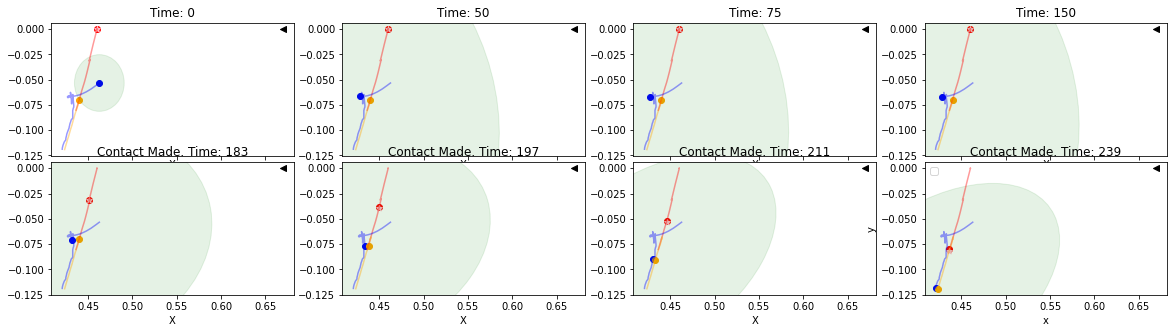

/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


[[ 0.00601499 -0.00040567]
 [-0.00040567  0.00576349]]
176
15


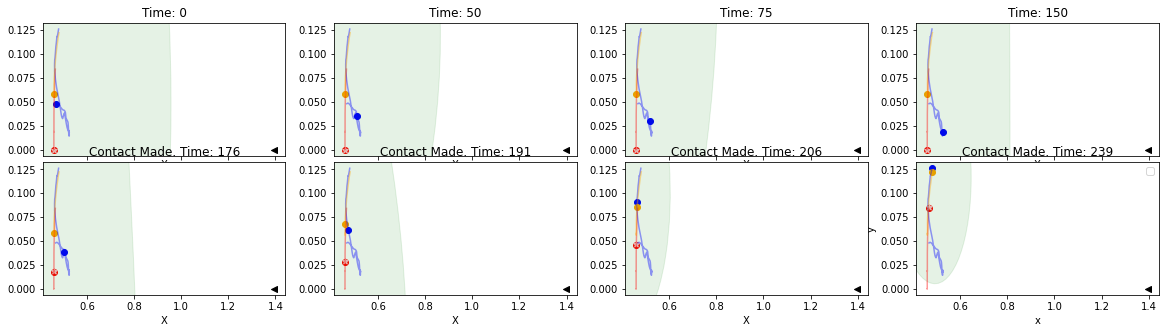

/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


[[ 0.01546663 -0.00012199]
 [-0.00012199  0.0803684 ]]
170
17


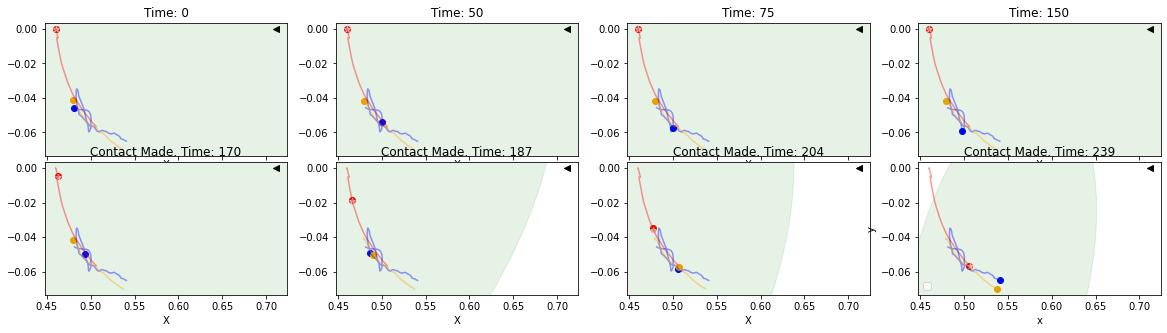

No handles with labels found to put in legend.


[[0.02574057 0.00258066]
 [0.00258066 0.01718425]]
179
15


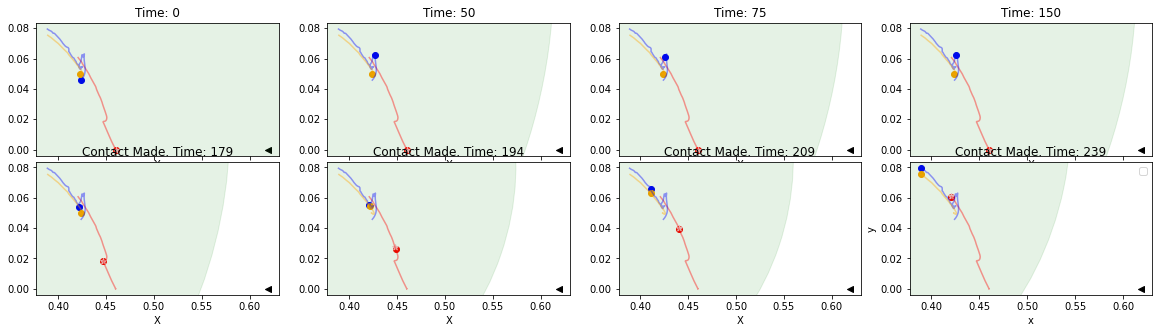

No handles with labels found to put in legend.


[[0.00625607 0.00150949]
 [0.00150949 0.0069049 ]]
182
14


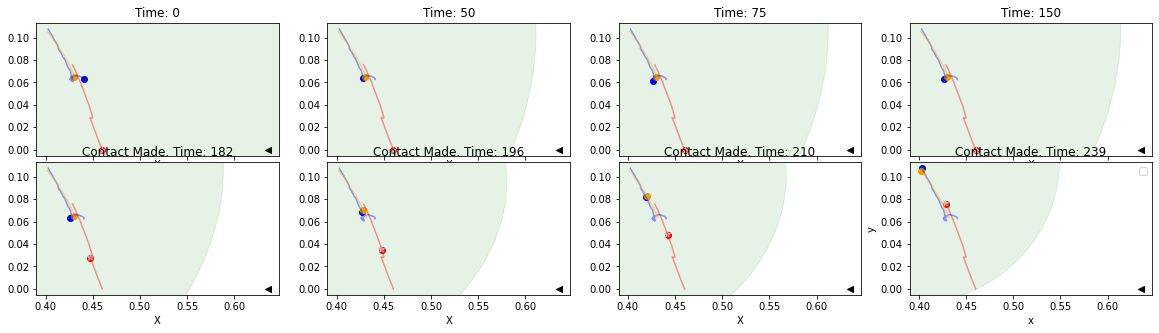

[[0.00616797 0.00123554]
 [0.00123554 0.00656767]]


In [147]:
for i in range(5):
    eval_2d_rollout(predicted_states[i], actual_states[i], predicted_sigmas[i], contact_states[i], 
                   actions=actions[i])

#     plot_kf_traj(predicted_states[i], actual_states[i], predicted_sigmas[i])
    print(np.mean(predicted_sigmas[i], 0))

14
14


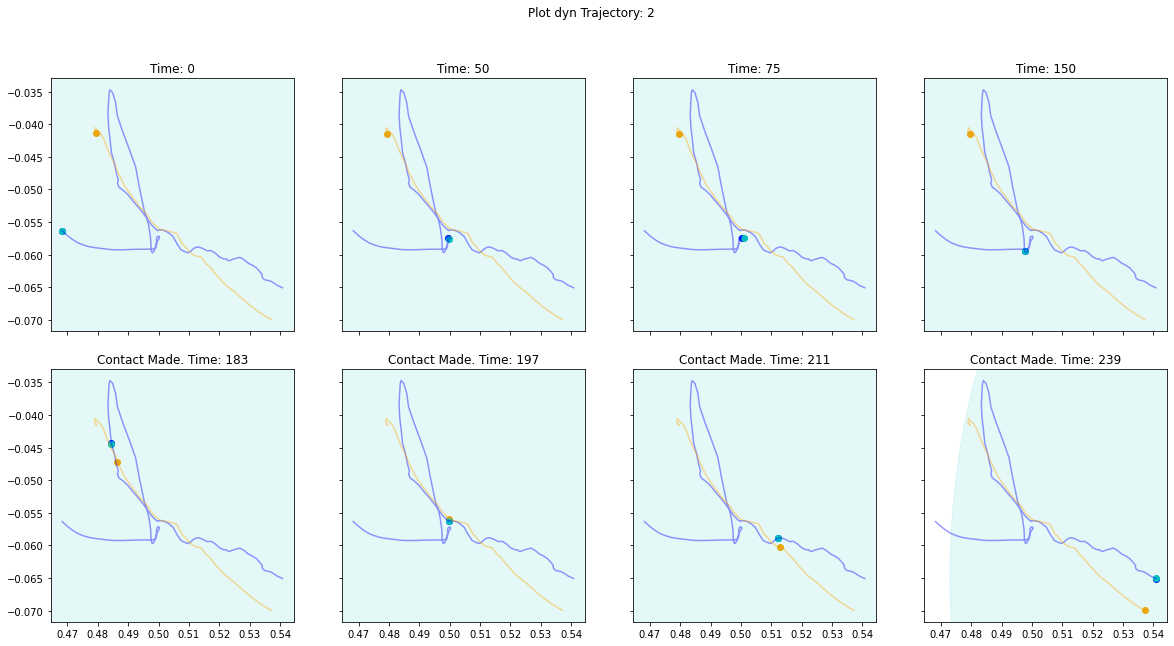

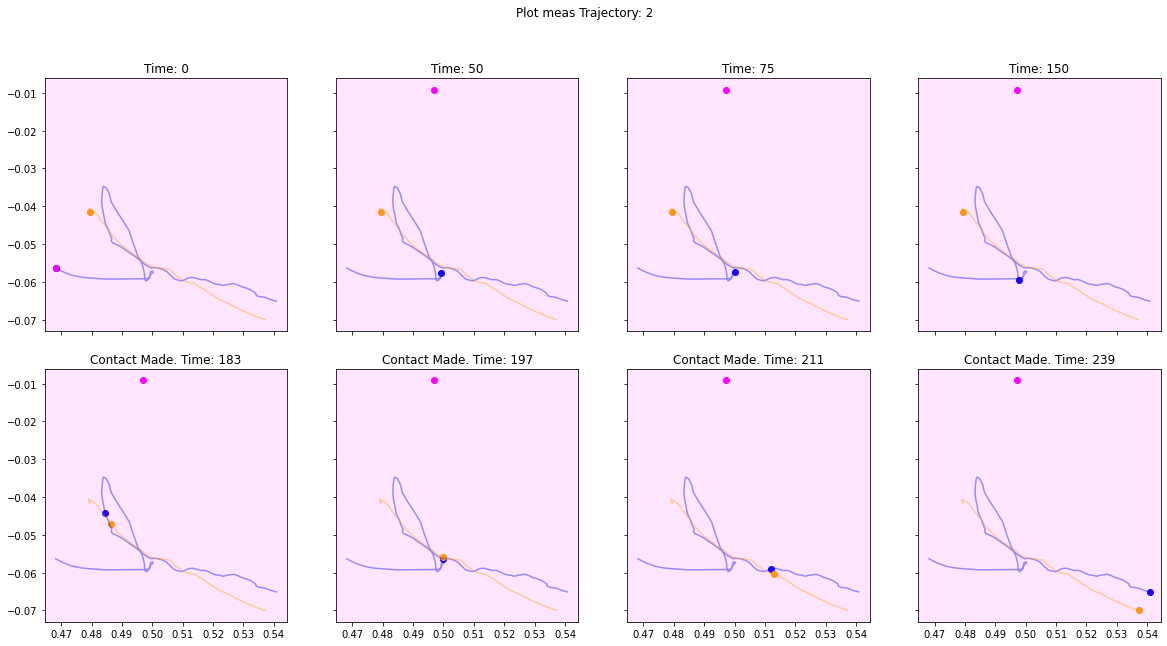

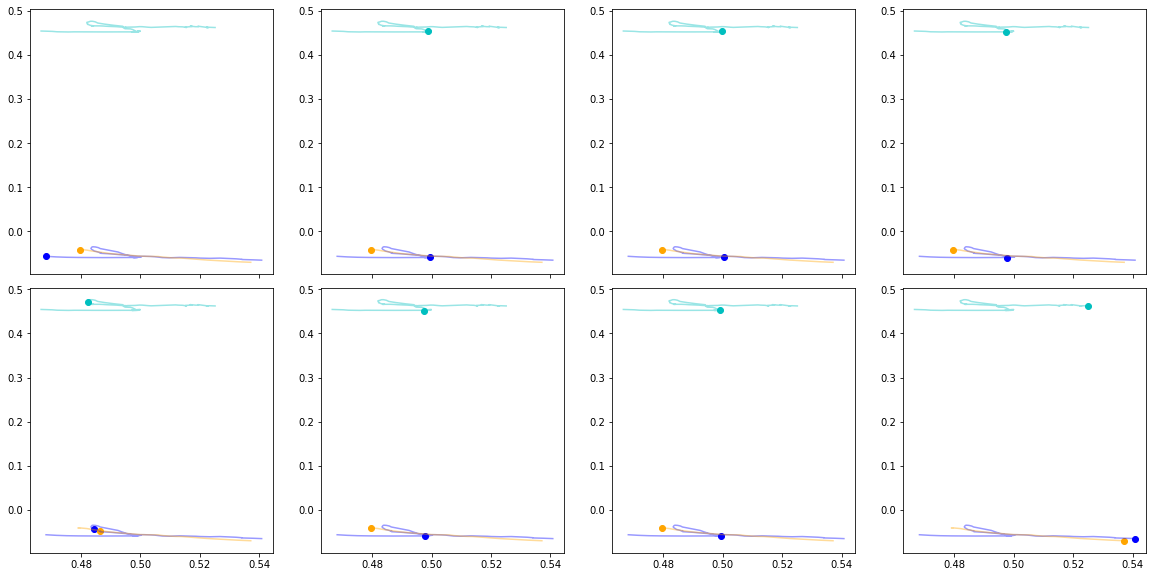

In [164]:
# eval_full_rollout(results, trajectories =[0], plot='all')
eval_full_rollout(results, trajectories =[2],plot='dyn')
eval_full_rollout(results, trajectories =[2],plot='meas')
plot_jacobian(results, trajectories=[2])


In [21]:
name = "ekfmse_measmse_fixed"
results = evaluations.ekf_eval_experiment(name, load_checkpoint="phase_3_e2e")

predicted_states = results['predicted_states']
actual_states = results['actual_states']
start_time = 0
rmse_x = (np.mean(
    (predicted_states[:, start_time:, 0] - actual_states[:, start_time:, 0]) ** 2))

rmse_y = (np.mean(
    (predicted_states[:, start_time:, 1] - actual_states[:, start_time:, 1]) ** 2))

print("rsme x: \n{} \n y:\n{}".format(rmse_x, rmse_y))
predicted_states, predicted_sigmas = utility.denormalize_state(results['predicted_states'], results['predicted_sigmas'])
actual_states = utility.denormalize(results['actual_states'], mean=[0.4970164, -0.00916641], std=[0.0572766, 0.06118315] )
print("Sigma average: ", np.mean(np.mean(predicted_sigmas,0), 0))
contact_states = results['contact_states']

print("Sigma average: ", np.mean(np.mean(predicted_sigmas,0), 0))

start_time = 0
rmse_x = np.sqrt(np.mean(
    (predicted_states[:, start_time:, 0] - actual_states[:, start_time:, 0]) ** 2))

rmse_y = np.sqrt(np.mean(
    (predicted_states[:, start_time:, 1] - actual_states[:, start_time:, 1]) ** 2))

print("rsme x: \n{} \n y:\n{}".format(rmse_x, rmse_y))


not using states!
[buddy-ekfmse_measmse_fixed] Using device: cuda
[buddy-ekfmse_measmse_fixed] Loaded metadata: {'batch': 128, 'ekf_loss': 'mse', 'epochs': 25, 'hidden_units': 128, 'image_blackout_ratio': 0.0, 'init state noise': 0.2, 'learnable_Q': False, 'learnable_Q_dynamics': False, 'measurement_loss': 'mse', 'obs_only': True, 'omnipush dataset': False, 'pretrain epochs': 5, 'sequential_image_rate': 1, 'set_r': None, 'start training from': 'ekf', 'start_timestep': 0, 'use_haptics': True, 'use_mass': False, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-ekfmse_measmse_fixed] Available checkpoint labels: ['0000000000105125', '0000000000105908', '0000000000106721', '0000000000107592', '0000000000108075', 'phase_0_dynamics_pretrain', 'phase_2_measurement_pretrain', 'phase_3_e2e']
[TrajectoriesFile-...le_push_1000.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_1000.hdf5" (mode r)>
[TrajectoriesFile-...le_push_1000.hdf5] Existing trajectory coun

states_update!  tensor([[[-1.0275e+00],
         [-1.1271e+00]],

        [[-6.3133e-01],
         [ 1.0201e+00]],

        [[-2.6541e-01],
         [-6.0261e-01]],

        [[-1.2183e+00],
         [ 9.4419e-01]],

        [[-1.1275e+00],
         [ 1.1790e+00]],

        [[ 1.3990e+00],
         [-7.8929e-01]],

        [[ 9.2206e-01],
         [ 2.0750e-01]],

        [[-1.1068e+00],
         [ 1.1461e+00]],

        [[-1.0541e+00],
         [-4.5259e-01]],

        [[-1.6149e+00],
         [-8.9063e-01]],

        [[ 8.1964e-01],
         [-1.1331e+00]],

        [[-8.4300e-01],
         [-1.1135e+00]],

        [[ 3.8648e-01],
         [ 5.3368e-01]],

        [[ 6.1835e-01],
         [ 2.2829e-01]],

        [[-1.0951e+00],
         [-7.6114e-01]],

        [[ 7.7999e-01],
         [-8.8086e-01]],

        [[-5.8638e-01],
         [ 9.7144e-01]],

        [[ 1.1735e+00],
         [-9.4607e-05]],

        [[-1.0797e-01],
         [ 2.9597e-01]],

        [[ 8.8698e-01],
         [

states_update!  tensor([[[-0.9728],
         [-1.0633]],

        [[-0.6441],
         [ 1.0991]],

        [[-0.1236],
         [-0.5982]],

        [[-1.2941],
         [ 0.9178]],

        [[-1.1886],
         [ 1.1629]],

        [[ 1.2855],
         [-0.7838]],

        [[ 0.9662],
         [ 0.2006]],

        [[-1.1981],
         [ 1.1282]],

        [[-1.1381],
         [-0.6423]],

        [[-1.2267],
         [-0.9420]],

        [[ 0.7770],
         [-1.1234]],

        [[-0.8053],
         [-1.0715]],

        [[ 0.3819],
         [ 0.4649]],

        [[ 0.6419],
         [ 0.2090]],

        [[-1.1338],
         [-0.7609]],

        [[ 0.7975],
         [-0.8792]],

        [[-0.6047],
         [ 0.9780]],

        [[ 1.3461],
         [-0.0050]],

        [[-0.0417],
         [ 0.3887]],

        [[ 0.9421],
         [-1.1028]],

        [[-1.1866],
         [-0.6258]],

        [[ 0.9628],
         [-1.0033]],

        [[-0.7775],
         [-1.0897]],

        [[-0.9382]

states_update!  tensor([[[-9.4099e-01],
         [-1.0183e+00]],

        [[-6.6786e-01],
         [ 1.0973e+00]],

        [[-7.6267e-02],
         [-6.1306e-01]],

        [[-1.2857e+00],
         [ 9.2229e-01]],

        [[-1.1749e+00],
         [ 1.1653e+00]],

        [[ 1.2482e+00],
         [-7.8965e-01]],

        [[ 1.0164e+00],
         [ 2.1429e-01]],

        [[-1.1829e+00],
         [ 1.1248e+00]],

        [[-1.1547e+00],
         [-7.2955e-01]],

        [[-1.1343e+00],
         [-9.5923e-01]],

        [[ 7.9667e-01],
         [-1.1292e+00]],

        [[-8.2248e-01],
         [-1.0624e+00]],

        [[ 3.9303e-01],
         [ 4.2363e-01]],

        [[ 7.1675e-01],
         [ 1.9661e-01]],

        [[-1.1584e+00],
         [-7.6388e-01]],

        [[ 8.4156e-01],
         [-8.9190e-01]],

        [[-6.3611e-01],
         [ 9.5289e-01]],

        [[ 1.3271e+00],
         [-1.3985e-04]],

        [[-2.5188e-02],
         [ 3.9588e-01]],

        [[ 9.7664e-01],
         [

states_update!  tensor([[[-9.4947e-01],
         [-9.9935e-01]],

        [[-7.1974e-01],
         [ 1.0907e+00]],

        [[-3.7651e-02],
         [-6.5821e-01]],

        [[-1.2567e+00],
         [ 9.3947e-01]],

        [[-1.1466e+00],
         [ 1.1811e+00]],

        [[ 1.2152e+00],
         [-8.1010e-01]],

        [[ 1.0492e+00],
         [ 2.5983e-01]],

        [[-1.1607e+00],
         [ 1.1404e+00]],

        [[-1.1456e+00],
         [-8.3006e-01]],

        [[-1.0868e+00],
         [-1.0012e+00]],

        [[ 8.4331e-01],
         [-1.1402e+00]],

        [[-8.6869e-01],
         [-1.0744e+00]],

        [[ 4.1814e-01],
         [ 3.7792e-01]],

        [[ 8.5008e-01],
         [ 2.2520e-01]],

        [[-1.1738e+00],
         [-7.6565e-01]],

        [[ 9.1731e-01],
         [-9.1630e-01]],

        [[-7.1166e-01],
         [ 9.2722e-01]],

        [[ 1.2645e+00],
         [-1.4148e-04]],

        [[-1.0277e-02],
         [ 3.7073e-01]],

        [[ 1.0197e+00],
         [

states_update!  tensor([[[-0.9704],
         [-0.9864]],

        [[-0.7515],
         [ 1.0847]],

        [[-0.0115],
         [-0.6920]],

        [[-1.2377],
         [ 0.9441]],

        [[-1.1205],
         [ 1.1838]],

        [[ 1.2028],
         [-0.8190]],

        [[ 1.0314],
         [ 0.2738]],

        [[-1.1395],
         [ 1.1435]],

        [[-1.1320],
         [-0.8634]],

        [[-1.0655],
         [-1.0059]],

        [[ 0.8774],
         [-1.1423]],

        [[-0.8905],
         [-1.0755]],

        [[ 0.4335],
         [ 0.3531]],

        [[ 0.8920],
         [ 0.2400]],

        [[-1.1808],
         [-0.7380]],

        [[ 0.9691],
         [-0.9235]],

        [[-0.7686],
         [ 0.9258]],

        [[ 1.2409],
         [ 0.0030]],

        [[-0.0025],
         [ 0.3408]],

        [[ 1.0443],
         [-1.0700]],

        [[-1.1496],
         [-0.8260]],

        [[ 1.0339],
         [-1.0517]],

        [[-0.8787],
         [-1.0698]],

        [[-0.9695]

states_update!  tensor([[[-9.9429e-01],
         [-1.0121e+00]],

        [[-7.7423e-01],
         [ 1.0751e+00]],

        [[ 1.2111e-02],
         [-7.3468e-01]],

        [[-1.2244e+00],
         [ 9.4686e-01]],

        [[-1.0985e+00],
         [ 1.1867e+00]],

        [[ 1.1912e+00],
         [-8.4187e-01]],

        [[ 1.0057e+00],
         [ 2.7093e-01]],

        [[-1.1221e+00],
         [ 1.1485e+00]],

        [[-1.1118e+00],
         [-9.1391e-01]],

        [[-1.0534e+00],
         [-1.0339e+00]],

        [[ 9.0398e-01],
         [-1.1471e+00]],

        [[-9.1099e-01],
         [-1.0910e+00]],

        [[ 4.4176e-01],
         [ 3.2187e-01]],

        [[ 9.0304e-01],
         [ 2.4296e-01]],

        [[-1.1661e+00],
         [-7.7102e-01]],

        [[ 1.0048e+00],
         [-9.4152e-01]],

        [[-8.1940e-01],
         [ 9.3086e-01]],

        [[ 1.2080e+00],
         [-1.4436e-04]],

        [[ 4.3474e-03],
         [ 3.0444e-01]],

        [[ 1.0623e+00],
         [

states_update!  tensor([[[-1.0091e+00],
         [-1.0691e+00]],

        [[-7.8972e-01],
         [ 1.0565e+00]],

        [[ 1.6975e-02],
         [-7.9461e-01]],

        [[-1.2194e+00],
         [ 9.7008e-01]],

        [[-1.0794e+00],
         [ 1.1872e+00]],

        [[ 1.1783e+00],
         [-8.8001e-01]],

        [[ 9.5716e-01],
         [ 2.0573e-01]],

        [[-1.1049e+00],
         [ 1.1508e+00]],

        [[-1.0883e+00],
         [-9.9273e-01]],

        [[-1.0570e+00],
         [-1.0930e+00]],

        [[ 9.2218e-01],
         [-1.1545e+00]],

        [[-9.3116e-01],
         [-1.1247e+00]],

        [[ 4.3983e-01],
         [ 2.6089e-01]],

        [[ 8.8497e-01],
         [ 2.0507e-01]],

        [[-1.1300e+00],
         [-8.7647e-01]],

        [[ 1.0222e+00],
         [-9.7137e-01]],

        [[-8.5611e-01],
         [ 9.2933e-01]],

        [[ 1.1756e+00],
         [-3.4069e-04]],

        [[ 1.0690e-02],
         [ 2.6261e-01]],

        [[ 1.0722e+00],
         [

states_update!  tensor([[[-1.0300],
         [-1.1411]],

        [[-0.8101],
         [ 1.0310]],

        [[ 0.0119],
         [-0.8747]],

        [[-1.2010],
         [ 0.9551]],

        [[-1.0528],
         [ 1.1712]],

        [[ 1.1627],
         [-0.9285]],

        [[ 0.9219],
         [ 0.1662]],

        [[-1.0764],
         [ 1.1370]],

        [[-1.0777],
         [-1.0872]],

        [[-1.0706],
         [-1.1668]],

        [[ 0.9434],
         [-1.1611]],

        [[-0.9605],
         [-1.1697]],

        [[ 0.4344],
         [ 0.1808]],

        [[ 0.8595],
         [ 0.1485]],

        [[-1.0900],
         [-0.9967]],

        [[ 1.0390],
         [-1.0079]],

        [[-0.8939],
         [ 0.9270]],

        [[ 1.1297],
         [-0.0050]],

        [[ 0.0181],
         [ 0.2022]],

        [[ 1.0819],
         [-1.0890]],

        [[-1.0777],
         [-1.0597]],

        [[ 1.0631],
         [-1.0926]],

        [[-0.9601],
         [-1.1697]],

        [[-1.0074]

states_update!  tensor([[[-1.0446e+00],
         [-1.1783e+00]],

        [[-8.2157e-01],
         [ 1.0224e+00]],

        [[ 7.0022e-03],
         [-9.1627e-01]],

        [[-1.1962e+00],
         [ 9.4737e-01]],

        [[-1.0472e+00],
         [ 1.1711e+00]],

        [[ 1.1554e+00],
         [-9.5384e-01]],

        [[ 9.0445e-01],
         [ 1.8527e-01]],

        [[-1.0637e+00],
         [ 1.1269e+00]],

        [[-1.0823e+00],
         [-1.1346e+00]],

        [[-1.0817e+00],
         [-1.2042e+00]],

        [[ 9.5615e-01],
         [-1.1629e+00]],

        [[-9.7967e-01],
         [-1.1951e+00]],

        [[ 4.2141e-01],
         [ 1.4321e-01]],

        [[ 8.4651e-01],
         [ 1.4916e-01]],

        [[-1.0777e+00],
         [-1.0486e+00]],

        [[ 1.0473e+00],
         [-1.0258e+00]],

        [[-9.1081e-01],
         [ 9.3636e-01]],

        [[ 1.1030e+00],
         [-1.9202e-03]],

        [[ 2.4813e-02],
         [ 1.6529e-01]],

        [[ 1.0870e+00],
         [

states_update!  tensor([[[-1.0613e+00],
         [-1.2032e+00]],

        [[-8.3384e-01],
         [ 1.0225e+00]],

        [[-3.1973e-03],
         [-9.5500e-01]],

        [[-1.2017e+00],
         [ 9.5721e-01]],

        [[-1.0471e+00],
         [ 1.1859e+00]],

        [[ 1.1492e+00],
         [-9.7503e-01]],

        [[ 8.7408e-01],
         [ 2.4528e-01]],

        [[-1.0605e+00],
         [ 1.1362e+00]],

        [[-1.0865e+00],
         [-1.1603e+00]],

        [[-1.0943e+00],
         [-1.2336e+00]],

        [[ 9.7446e-01],
         [-1.1609e+00]],

        [[-1.0073e+00],
         [-1.2214e+00]],

        [[ 3.6998e-01],
         [ 1.1472e-01]],

        [[ 8.1569e-01],
         [ 1.8034e-01]],

        [[-1.0638e+00],
         [-1.0457e+00]],

        [[ 1.0614e+00],
         [-1.0392e+00]],

        [[-9.2240e-01],
         [ 9.5509e-01]],

        [[ 1.0707e+00],
         [-1.5452e-04]],

        [[ 4.1621e-02],
         [ 9.7909e-02]],

        [[ 1.0942e+00],
         [

states_update!  tensor([[[-1.0663],
         [-1.2013]],

        [[-0.8386],
         [ 1.0270]],

        [[-0.0139],
         [-0.9696]],

        [[-1.2000],
         [ 0.9527]],

        [[-1.0442],
         [ 1.1940]],

        [[ 1.1472],
         [-0.9800]],

        [[ 0.8507],
         [ 0.2747]],

        [[-1.0578],
         [ 1.1438]],

        [[-1.0823],
         [-1.1506]],

        [[-1.0975],
         [-1.2363]],

        [[ 0.9856],
         [-1.1585]],

        [[-1.0236],
         [-1.2317]],

        [[ 0.3202],
         [ 0.0962]],

        [[ 0.7879],
         [ 0.2052]],

        [[-1.0445],
         [-1.0023]],

        [[ 1.0729],
         [-1.0403]],

        [[-0.9229],
         [ 0.9656]],

        [[ 1.0540],
         [ 0.0041]],

        [[ 0.0543],
         [ 0.0327]],

        [[ 1.0986],
         [-1.0959]],

        [[-1.0671],
         [-1.0992]],

        [[ 1.0786],
         [-1.1085]],

        [[-1.0253],
         [-1.2320]],

        [[-1.0486]

states_update!  tensor([[[-1.0714e+00],
         [-1.2026e+00]],

        [[-8.4153e-01],
         [ 1.0256e+00]],

        [[-2.9024e-02],
         [-9.8974e-01]],

        [[-1.2029e+00],
         [ 9.5414e-01]],

        [[-1.0339e+00],
         [ 1.1933e+00]],

        [[ 1.1443e+00],
         [-9.9205e-01]],

        [[ 8.1287e-01],
         [ 2.5780e-01]],

        [[-1.0544e+00],
         [ 1.1461e+00]],

        [[-1.0743e+00],
         [-1.1432e+00]],

        [[-1.1049e+00],
         [-1.2476e+00]],

        [[ 9.9819e-01],
         [-1.1548e+00]],

        [[-1.0459e+00],
         [-1.2484e+00]],

        [[ 2.6945e-01],
         [ 2.0378e-02]],

        [[ 7.3900e-01],
         [ 2.0791e-01]],

        [[-1.0456e+00],
         [-9.8386e-01]],

        [[ 1.0819e+00],
         [-1.0459e+00]],

        [[-9.1719e-01],
         [ 9.7276e-01]],

        [[ 1.0311e+00],
         [-1.2597e-04]],

        [[ 7.0115e-02],
         [-6.9451e-02]],

        [[ 1.1036e+00],
         [

states_update!  tensor([[[-1.0796e+00],
         [-1.2190e+00]],

        [[-8.4122e-01],
         [ 1.0221e+00]],

        [[-3.3629e-02],
         [-1.0078e+00]],

        [[-1.2018e+00],
         [ 9.5101e-01]],

        [[-1.0295e+00],
         [ 1.1946e+00]],

        [[ 1.1426e+00],
         [-1.0023e+00]],

        [[ 7.9278e-01],
         [ 2.3220e-01]],

        [[-1.0500e+00],
         [ 1.1460e+00]],

        [[-1.0765e+00],
         [-1.1623e+00]],

        [[-1.1147e+00],
         [-1.2646e+00]],

        [[ 1.0042e+00],
         [-1.1529e+00]],

        [[-1.0605e+00],
         [-1.2628e+00]],

        [[ 2.5505e-01],
         [-4.1345e-02]],

        [[ 7.1290e-01],
         [ 1.8470e-01]],

        [[-1.0539e+00],
         [-1.0112e+00]],

        [[ 1.0848e+00],
         [-1.0514e+00]],

        [[-9.1115e-01],
         [ 9.6998e-01]],

        [[ 1.0217e+00],
         [-1.5726e-04]],

        [[ 7.9138e-02],
         [-1.3766e-01]],

        [[ 1.1056e+00],
         [

states_update!  tensor([[[-1.0961],
         [-1.2520]],

        [[-0.8383],
         [ 1.0067]],

        [[-0.0298],
         [-1.0441]],

        [[-1.2042],
         [ 0.9503]],

        [[-1.0156],
         [ 1.1770]],

        [[ 1.1395],
         [-1.0207]],

        [[ 0.7738],
         [ 0.1672]],

        [[-1.0456],
         [ 1.1436]],

        [[-1.0887],
         [-1.2045]],

        [[-1.1361],
         [-1.2986]],

        [[ 1.0103],
         [-1.1519]],

        [[-1.0793],
         [-1.2865]],

        [[ 0.2747],
         [-0.1471]],

        [[ 0.6935],
         [ 0.1227]],

        [[-1.0610],
         [-1.0793]],

        [[ 1.0843],
         [-1.0625]],

        [[-0.9016],
         [ 0.9542]],

        [[ 1.0109],
         [-0.0031]],

        [[ 0.0916],
         [-0.2413]],

        [[ 1.1071],
         [-1.1018]],

        [[-1.0647],
         [-1.1551]],

        [[ 1.0870],
         [-1.1164]],

        [[-1.0798],
         [-1.2862]],

        [[-1.0887]

states_update!  tensor([[[-1.1207],
         [-1.2833]],

        [[-0.8207],
         [ 0.9970]],

        [[-0.0336],
         [-1.0779]],

        [[-1.2083],
         [ 0.9374]],

        [[-1.0157],
         [ 1.1729]],

        [[ 1.1373],
         [-1.0374]],

        [[ 0.7826],
         [ 0.2033]],

        [[-1.0386],
         [ 1.1253]],

        [[-1.1066],
         [-1.2405]],

        [[-1.1658],
         [-1.3333]],

        [[ 1.0176],
         [-1.1486]],

        [[-1.1081],
         [-1.3138]],

        [[ 0.4091],
         [-0.2556]],

        [[ 0.6985],
         [ 0.1295]],

        [[-1.0675],
         [-1.1240]],

        [[ 1.0837],
         [-1.0719]],

        [[-0.8863],
         [ 0.9282]],

        [[ 0.9998],
         [-0.0023]],

        [[ 0.1130],
         [-0.3977]],

        [[ 1.1095],
         [-1.1049]],

        [[-1.0792],
         [-1.1933]],

        [[ 1.0892],
         [-1.1194]],

        [[-1.1071],
         [-1.3128]],

        [[-1.1148]

states_update!  tensor([[[-1.1140],
         [-1.2482]],

        [[-0.7989],
         [ 1.0022]],

        [[-0.0565],
         [-1.0748]],

        [[-1.2159],
         [ 0.9454]],

        [[-1.0185],
         [ 1.1841]],

        [[ 1.1420],
         [-1.0276]],

        [[ 0.7789],
         [ 0.2736]],

        [[-1.0399],
         [ 1.1342]],

        [[-1.0777],
         [-1.1743]],

        [[-1.1720],
         [-1.3180]],

        [[ 1.0285],
         [-1.1426]],

        [[-1.1309],
         [-1.3166]],

        [[ 0.4952],
         [-0.2414]],

        [[ 0.6915],
         [ 0.1894]],

        [[-1.0059],
         [-0.9644]],

        [[ 1.0941],
         [-1.0643]],

        [[-0.8684],
         [ 0.9175]],

        [[ 0.9971],
         [ 0.0152]],

        [[ 0.1242],
         [-0.5251]],

        [[ 1.1138],
         [-1.1012]],

        [[-1.0287],
         [-1.0866]],

        [[ 1.0950],
         [-1.1168]],

        [[-1.1287],
         [-1.3139]],

        [[-1.1274]

states_update!  tensor([[[-1.1166e+00],
         [-1.2514e+00]],

        [[-7.8863e-01],
         [ 9.9394e-01]],

        [[-5.5137e-02],
         [-1.0807e+00]],

        [[-1.2174e+00],
         [ 9.5301e-01]],

        [[-1.0204e+00],
         [ 1.1910e+00]],

        [[ 1.1427e+00],
         [-1.0309e+00]],

        [[ 7.6004e-01],
         [ 2.3457e-01]],

        [[-1.0430e+00],
         [ 1.1461e+00]],

        [[-1.0723e+00],
         [-1.1752e+00]],

        [[-1.1787e+00],
         [-1.3253e+00]],

        [[ 1.0342e+00],
         [-1.1402e+00]],

        [[-1.1437e+00],
         [-1.3244e+00]],

        [[ 5.0089e-01],
         [-2.4089e-01]],

        [[ 6.8306e-01],
         [ 1.8624e-01]],

        [[-1.0278e+00],
         [-9.8057e-01]],

        [[ 1.0973e+00],
         [-1.0649e+00]],

        [[-8.6041e-01],
         [ 9.0854e-01]],

        [[ 9.9291e-01],
         [-1.6466e-04]],

        [[ 1.2085e-01],
         [-5.8873e-01]],

        [[ 1.1158e+00],
         [

states_update!  tensor([[[-1.1423],
         [-1.2918]],

        [[-0.7799],
         [ 0.9612]],

        [[-0.0389],
         [-1.1133]],

        [[-1.2094],
         [ 0.9395]],

        [[-1.0117],
         [ 1.1656]],

        [[ 1.1392],
         [-1.0486]],

        [[ 0.7652],
         [ 0.1555]],

        [[-1.0313],
         [ 1.1297]],

        [[-1.0981],
         [-1.2305]],

        [[-1.2029],
         [-1.3635]],

        [[ 1.0355],
         [-1.1411]],

        [[-1.1691],
         [-1.3502]],

        [[ 0.5075],
         [-0.2966]],

        [[ 0.6975],
         [ 0.1079]],

        [[-1.0558],
         [-1.0961]],

        [[ 1.0917],
         [-1.0763]],

        [[-0.8553],
         [ 0.8699]],

        [[ 0.9907],
         [-0.0085]],

        [[ 0.0996],
         [-0.6885]],

        [[ 1.1155],
         [-1.1066]],

        [[-1.0459],
         [-1.1600]],

        [[ 1.0969],
         [-1.1202]],

        [[-1.1659],
         [-1.3468]],

        [[-1.1632]

states_update!  tensor([[[-1.1583e+00],
         [-1.2964e+00]],

        [[-7.7503e-01],
         [ 9.5421e-01]],

        [[-4.9031e-02],
         [-1.1142e+00]],

        [[-1.2140e+00],
         [ 9.3936e-01]],

        [[-1.0277e+00],
         [ 1.1793e+00]],

        [[ 1.1358e+00],
         [-1.0516e+00]],

        [[ 7.7173e-01],
         [ 2.2915e-01]],

        [[-1.0412e+00],
         [ 1.1274e+00]],

        [[-1.1022e+00],
         [-1.2248e+00]],

        [[-1.2160e+00],
         [-1.3724e+00]],

        [[ 1.0349e+00],
         [-1.1415e+00]],

        [[-1.1910e+00],
         [-1.3637e+00]],

        [[ 4.7644e-01],
         [-3.0034e-01]],

        [[ 7.1694e-01],
         [ 1.5103e-01]],

        [[-1.0545e+00],
         [-1.0872e+00]],

        [[ 1.0889e+00],
         [-1.0775e+00]],

        [[-8.5456e-01],
         [ 8.5786e-01]],

        [[ 9.8797e-01],
         [-1.5678e-04]],

        [[ 8.2036e-02],
         [-7.6595e-01]],

        [[ 1.1126e+00],
         [

states_update!  tensor([[[-1.1451],
         [-1.2476]],

        [[-0.7674],
         [ 0.9674]],

        [[-0.0752],
         [-1.0965]],

        [[-1.2042],
         [ 0.9511]],

        [[-1.0277],
         [ 1.1901]],

        [[ 1.1385],
         [-1.0344]],

        [[ 0.7504],
         [ 0.2609]],

        [[-1.0496],
         [ 1.1390]],

        [[-1.0537],
         [-1.1350]],

        [[-1.2060],
         [-1.3396]],

        [[ 1.0362],
         [-1.1399]],

        [[-1.2004],
         [-1.3601]],

        [[ 0.3867],
         [-0.2283]],

        [[ 0.7085],
         [ 0.1972]],

        [[-1.0017],
         [-0.9200]],

        [[ 1.0959],
         [-1.0651]],

        [[-0.8513],
         [ 0.8707]],

        [[ 0.9827],
         [ 0.0066]],

        [[ 0.0877],
         [-0.8225]],

        [[ 1.1100],
         [-1.1057]],

        [[-0.9774],
         [-1.0257]],

        [[ 1.0936],
         [-1.1206]],

        [[-1.1961],
         [-1.3533]],

        [[-1.1856]

states_update!  tensor([[[-1.1610],
         [-1.2930]],

        [[-0.7640],
         [ 0.9441]],

        [[-0.0560],
         [-1.1190]],

        [[-1.1866],
         [ 0.9363]],

        [[-1.0108],
         [ 1.1677]],

        [[ 1.1315],
         [-1.0524]],

        [[ 0.7337],
         [ 0.1573]],

        [[-1.0440],
         [ 1.1281]],

        [[-1.0816],
         [-1.2036]],

        [[-1.2178],
         [-1.3762]],

        [[ 1.0308],
         [-1.1431]],

        [[-1.2095],
         [-1.3843]],

        [[ 0.3812],
         [-0.2631]],

        [[ 0.6935],
         [ 0.1074]],

        [[-1.0459],
         [-1.0524]],

        [[ 1.0872],
         [-1.0774]],

        [[-0.8513],
         [ 0.8507]],

        [[ 0.9771],
         [-0.0044]],

        [[ 0.0877],
         [-0.8690]],

        [[ 1.1047],
         [-1.1124]],

        [[-1.0106],
         [-1.1087]],

        [[ 1.0885],
         [-1.1253]],

        [[-1.2046],
         [-1.3782]],

        [[-1.1961]

states_update!  tensor([[[-1.1739e+00],
         [-1.3129e+00]],

        [[-7.6461e-01],
         [ 9.5030e-01]],

        [[-6.5671e-02],
         [-1.1205e+00]],

        [[-1.1814e+00],
         [ 9.4266e-01]],

        [[-1.0223e+00],
         [ 1.1854e+00]],

        [[ 1.1269e+00],
         [-1.0554e+00]],

        [[ 7.5321e-01],
         [ 2.2017e-01]],

        [[-1.0479e+00],
         [ 1.1316e+00]],

        [[-1.1007e+00],
         [-1.2218e+00]],

        [[-1.2264e+00],
         [-1.3915e+00]],

        [[ 1.0276e+00],
         [-1.1446e+00]],

        [[-1.2194e+00],
         [-1.3988e+00]],

        [[ 3.9440e-01],
         [-2.6748e-01]],

        [[ 7.0648e-01],
         [ 1.1605e-01]],

        [[-1.0597e+00],
         [-1.0894e+00]],

        [[ 1.0825e+00],
         [-1.0807e+00]],

        [[-8.5618e-01],
         [ 8.4962e-01]],

        [[ 9.7479e-01],
         [-1.5928e-04]],

        [[ 8.9156e-02],
         [-9.0032e-01]],

        [[ 1.0999e+00],
         [

states_update!  tensor([[[-1.1640e+00],
         [-1.2795e+00]],

        [[-7.6368e-01],
         [ 9.7410e-01]],

        [[-9.1953e-02],
         [-1.0997e+00]],

        [[-1.1728e+00],
         [ 9.5341e-01]],

        [[-1.0198e+00],
         [ 1.1931e+00]],

        [[ 1.1285e+00],
         [-1.0419e+00]],

        [[ 7.4935e-01],
         [ 2.6708e-01]],

        [[-1.0475e+00],
         [ 1.1402e+00]],

        [[-1.0852e+00],
         [-1.1645e+00]],

        [[-1.2190e+00],
         [-1.3703e+00]],

        [[ 1.0293e+00],
         [-1.1418e+00]],

        [[-1.2224e+00],
         [-1.3931e+00]],

        [[ 3.9600e-01],
         [-2.2318e-01]],

        [[ 6.8156e-01],
         [ 1.9410e-01]],

        [[-1.0275e+00],
         [-9.7214e-01]],

        [[ 1.0874e+00],
         [-1.0713e+00]],

        [[-8.5688e-01],
         [ 8.8610e-01]],

        [[ 9.6939e-01],
         [-1.1813e-04]],

        [[ 8.7894e-02],
         [-9.1950e-01]],

        [[ 1.0974e+00],
         [

states_update!  tensor([[[-1.1760e+00],
         [-1.3151e+00]],

        [[-7.6362e-01],
         [ 9.6945e-01]],

        [[-6.0596e-02],
         [-1.1207e+00]],

        [[-1.1613e+00],
         [ 9.3402e-01]],

        [[-9.9810e-01],
         [ 1.1643e+00]],

        [[ 1.1234e+00],
         [-1.0548e+00]],

        [[ 7.3198e-01],
         [ 1.6046e-01]],

        [[-1.0334e+00],
         [ 1.1256e+00]],

        [[-1.1105e+00],
         [-1.2199e+00]],

        [[-1.2309e+00],
         [-1.3992e+00]],

        [[ 1.0252e+00],
         [-1.1435e+00]],

        [[-1.2290e+00],
         [-1.4110e+00]],

        [[ 4.2629e-01],
         [-2.4924e-01]],

        [[ 6.6873e-01],
         [ 1.1380e-01]],

        [[-1.0581e+00],
         [-1.0772e+00]],

        [[ 1.0800e+00],
         [-1.0808e+00]],

        [[-8.5904e-01],
         [ 8.7927e-01]],

        [[ 9.6967e-01],
         [-1.6002e-04]],

        [[ 8.3788e-02],
         [-9.3682e-01]],

        [[ 1.0936e+00],
         [

states_update!  tensor([[[-1.1903e+00],
         [-1.3360e+00]],

        [[-7.6528e-01],
         [ 9.7868e-01]],

        [[-6.0706e-02],
         [-1.1269e+00]],

        [[-1.1691e+00],
         [ 9.3809e-01]],

        [[-1.0156e+00],
         [ 1.1836e+00]],

        [[ 1.1184e+00],
         [-1.0598e+00]],

        [[ 7.4769e-01],
         [ 2.2806e-01]],

        [[-1.0401e+00],
         [ 1.1303e+00]],

        [[-1.1344e+00],
         [-1.2506e+00]],

        [[-1.2439e+00],
         [-1.4156e+00]],

        [[ 1.0231e+00],
         [-1.1440e+00]],

        [[-1.2400e+00],
         [-1.4236e+00]],

        [[ 4.2663e-01],
         [-2.6244e-01]],

        [[ 6.8748e-01],
         [ 1.4558e-01]],

        [[-1.0754e+00],
         [-1.1158e+00]],

        [[ 1.0739e+00],
         [-1.0845e+00]],

        [[-8.6094e-01],
         [ 8.8730e-01]],

        [[ 9.6989e-01],
         [-1.5966e-04]],

        [[ 4.6545e-02],
         [-9.4851e-01]],

        [[ 1.0902e+00],
         [

states_update!  tensor([[[-1.1843],
         [-1.3140]],

        [[-0.7679],
         [ 0.9977]],

        [[-0.0800],
         [-1.1074]],

        [[-1.1682],
         [ 0.9493]],

        [[-1.0130],
         [ 1.1940]],

        [[ 1.1196],
         [-1.0495]],

        [[ 0.7469],
         [ 0.2605]],

        [[-1.0418],
         [ 1.1408]],

        [[-1.1247],
         [-1.2122]],

        [[-1.2408],
         [-1.4017]],

        [[ 1.0247],
         [-1.1414]],

        [[-1.2437],
         [-1.4191]],

        [[ 0.3782],
         [-0.2131]],

        [[ 0.6908],
         [ 0.1894]],

        [[-1.0301],
         [-0.9993]],

        [[ 1.0774],
         [-1.0764]],

        [[-0.8548],
         [ 0.9112]],

        [[ 0.9709],
         [ 0.0076]],

        [[-0.0026],
         [-0.9514]],

        [[ 1.0892],
         [-1.1145]],

        [[-1.0162],
         [-1.0826]],

        [[ 1.0754],
         [-1.1276]],

        [[-1.2403],
         [-1.4165]],

        [[-1.2290]

states_update!  tensor([[[-1.1774e+00],
         [-1.3025e+00]],

        [[-7.7963e-01],
         [ 9.9430e-01]],

        [[-8.0267e-02],
         [-1.0977e+00]],

        [[-1.1620e+00],
         [ 9.4631e-01]],

        [[-1.0076e+00],
         [ 1.1934e+00]],

        [[ 1.1221e+00],
         [-1.0435e+00]],

        [[ 7.5498e-01],
         [ 2.4746e-01]],

        [[-1.0380e+00],
         [ 1.1400e+00]],

        [[-1.1143e+00],
         [-1.1947e+00]],

        [[-1.2353e+00],
         [-1.3932e+00]],

        [[ 1.0263e+00],
         [-1.1406e+00]],

        [[-1.2439e+00],
         [-1.4195e+00]],

        [[ 3.8967e-01],
         [-1.9514e-01]],

        [[ 6.8865e-01],
         [ 1.8670e-01]],

        [[-1.0473e+00],
         [-9.8014e-01]],

        [[ 1.0807e+00],
         [-1.0723e+00]],

        [[-8.5222e-01],
         [ 9.1190e-01]],

        [[ 9.6767e-01],
         [-1.5977e-04]],

        [[-2.7438e-02],
         [-9.5467e-01]],

        [[ 1.0896e+00],
         [

states_update!  tensor([[[-1.1838e+00],
         [-1.3238e+00]],

        [[-7.8383e-01],
         [ 9.8568e-01]],

        [[-5.7349e-02],
         [-1.1116e+00]],

        [[-1.1582e+00],
         [ 9.3493e-01]],

        [[-9.9449e-01],
         [ 1.1698e+00]],

        [[ 1.1204e+00],
         [-1.0515e+00]],

        [[ 7.4145e-01],
         [ 1.8566e-01]],

        [[-1.0334e+00],
         [ 1.1320e+00]],

        [[-1.1249e+00],
         [-1.2276e+00]],

        [[-1.2412e+00],
         [-1.4102e+00]],

        [[ 1.0235e+00],
         [-1.1424e+00]],

        [[-1.2455e+00],
         [-1.4289e+00]],

        [[ 4.2131e-01],
         [-2.3187e-01]],

        [[ 6.8692e-01],
         [ 1.3860e-01]],

        [[-1.0561e+00],
         [-1.0431e+00]],

        [[ 1.0768e+00],
         [-1.0782e+00]],

        [[-8.5217e-01],
         [ 8.9829e-01]],

        [[ 9.6220e-01],
         [-1.6078e-04]],

        [[-3.3926e-02],
         [-9.5920e-01]],

        [[ 1.0892e+00],
         [

states_update!  tensor([[[-1.1931e+00],
         [-1.3457e+00]],

        [[-7.8772e-01],
         [ 9.8389e-01]],

        [[-4.8575e-02],
         [-1.1235e+00]],

        [[-1.1623e+00],
         [ 9.3482e-01]],

        [[-1.0087e+00],
         [ 1.1822e+00]],

        [[ 1.1184e+00],
         [-1.0596e+00]],

        [[ 7.5461e-01],
         [ 1.8814e-01]],

        [[-1.0356e+00],
         [ 1.1311e+00]],

        [[-1.1398e+00],
         [-1.2611e+00]],

        [[-1.2486e+00],
         [-1.4263e+00]],

        [[ 1.0225e+00],
         [-1.1449e+00]],

        [[-1.2490e+00],
         [-1.4390e+00]],

        [[ 4.5021e-01],
         [-2.5747e-01]],

        [[ 6.9951e-01],
         [ 1.2465e-01]],

        [[-1.0695e+00],
         [-1.1032e+00]],

        [[ 1.0729e+00],
         [-1.0847e+00]],

        [[-8.5227e-01],
         [ 8.9204e-01]],

        [[ 9.5546e-01],
         [-1.6159e-04]],

        [[-4.1348e-02],
         [-9.6426e-01]],

        [[ 1.0891e+00],
         [

states_update!  tensor([[[-1.1960e+00],
         [-1.3485e+00]],

        [[-7.8813e-01],
         [ 9.8998e-01]],

        [[-5.4762e-02],
         [-1.1234e+00]],

        [[-1.1686e+00],
         [ 9.4276e-01]],

        [[-1.0099e+00],
         [ 1.1831e+00]],

        [[ 1.1186e+00],
         [-1.0598e+00]],

        [[ 7.6319e-01],
         [ 2.2393e-01]],

        [[-1.0377e+00],
         [ 1.1315e+00]],

        [[-1.1439e+00],
         [-1.2643e+00]],

        [[-1.2504e+00],
         [-1.4281e+00]],

        [[ 1.0231e+00],
         [-1.1458e+00]],

        [[-1.2518e+00],
         [-1.4417e+00]],

        [[ 4.5426e-01],
         [-2.5726e-01]],

        [[ 7.0791e-01],
         [ 1.3442e-01]],

        [[-1.0712e+00],
         [-1.1038e+00]],

        [[ 1.0731e+00],
         [-1.0856e+00]],

        [[-8.5159e-01],
         [ 8.9257e-01]],

        [[ 9.5175e-01],
         [-1.6208e-04]],

        [[-4.5206e-02],
         [-9.6641e-01]],

        [[ 1.0894e+00],
         [

states_update!  tensor([[[-1.1933],
         [-1.3383]],

        [[-0.7848],
         [ 0.9941]],

        [[-0.0648],
         [-1.1156]],

        [[-1.1711],
         [ 0.9496]],

        [[-1.0129],
         [ 1.1866]],

        [[ 1.1207],
         [-1.0561]],

        [[ 0.7564],
         [ 0.2529]],

        [[-1.0416],
         [ 1.1345]],

        [[-1.1393],
         [-1.2456]],

        [[-1.2474],
         [-1.4191]],

        [[ 1.0259],
         [-1.1466]],

        [[-1.2528],
         [-1.4393]],

        [[ 0.4417],
         [-0.2452]],

        [[ 0.7123],
         [ 0.1672]],

        [[-1.0531],
         [-1.0554]],

        [[ 1.0765],
         [-1.0828]],

        [[-0.8488],
         [ 0.9005]],

        [[ 0.9472],
         [ 0.0123]],

        [[-0.0496],
         [-0.9687]],

        [[ 1.0905],
         [-1.1193]],

        [[-1.0293],
         [-1.1149]],

        [[ 1.0756],
         [-1.1327]],

        [[-1.2494],
         [-1.4347]],

        [[-1.2375]

states_update!  tensor([[[-1.1833],
         [-1.3133]],

        [[-0.7814],
         [ 0.9949]],

        [[-0.0775],
         [-1.1065]],

        [[-1.1720],
         [ 0.9548]],

        [[-1.0140],
         [ 1.1880]],

        [[ 1.1234],
         [-1.0500]],

        [[ 0.7494],
         [ 0.2430]],

        [[-1.0447],
         [ 1.1387]],

        [[-1.1239],
         [-1.2053]],

        [[-1.2400],
         [-1.4004]],

        [[ 1.0266],
         [-1.1471]],

        [[-1.2503],
         [-1.4316]],

        [[ 0.4217],
         [-0.2250]],

        [[ 0.7095],
         [ 0.1695]],

        [[-1.0282],
         [-0.9726]],

        [[ 1.0815],
         [-1.0767]],

        [[-0.8467],
         [ 0.9006]],

        [[ 0.9426],
         [ 0.0173]],

        [[-0.0518],
         [-0.9698]],

        [[ 1.0916],
         [-1.1182]],

        [[-0.9993],
         [-1.0574]],

        [[ 1.0771],
         [-1.1321]],

        [[-1.2476],
         [-1.4285]],

        [[-1.2339]

states_update!  tensor([[[-1.1772e+00],
         [-1.3052e+00]],

        [[-7.7622e-01],
         [ 9.8913e-01]],

        [[-7.2362e-02],
         [-1.1049e+00]],

        [[-1.1669e+00],
         [ 9.4650e-01]],

        [[-1.0082e+00],
         [ 1.1810e+00]],

        [[ 1.1255e+00],
         [-1.0500e+00]],

        [[ 7.5527e-01],
         [ 2.5182e-01]],

        [[-1.0379e+00],
         [ 1.1290e+00]],

        [[-1.1141e+00],
         [-1.1929e+00]],

        [[-1.2348e+00],
         [-1.3944e+00]],

        [[ 1.0295e+00],
         [-1.1482e+00]],

        [[-1.2487e+00],
         [-1.4311e+00]],

        [[ 3.9861e-01],
         [-2.1788e-01]],

        [[ 7.0208e-01],
         [ 1.8787e-01]],

        [[-1.0474e+00],
         [-9.7087e-01]],

        [[ 1.0837e+00],
         [-1.0770e+00]],

        [[-8.4323e-01],
         [ 9.0449e-01]],

        [[ 9.3443e-01],
         [-1.3691e-04]],

        [[-5.4108e-02],
         [-9.7189e-01]],

        [[ 1.0928e+00],
         [

states_update!  tensor([[[-1.1806e+00],
         [-1.3196e+00]],

        [[-7.7385e-01],
         [ 9.7700e-01]],

        [[-5.7515e-02],
         [-1.1167e+00]],

        [[-1.1660e+00],
         [ 9.3922e-01]],

        [[-1.0006e+00],
         [ 1.1647e+00]],

        [[ 1.1249e+00],
         [-1.0569e+00]],

        [[ 7.4695e-01],
         [ 2.0705e-01]],

        [[-1.0422e+00],
         [ 1.1305e+00]],

        [[-1.1193e+00],
         [-1.2152e+00]],

        [[-1.2368e+00],
         [-1.4044e+00]],

        [[ 1.0295e+00],
         [-1.1500e+00]],

        [[-1.2493e+00],
         [-1.4373e+00]],

        [[ 3.9730e-01],
         [-2.3653e-01]],

        [[ 6.9580e-01],
         [ 1.6845e-01]],

        [[-1.0569e+00],
         [-1.0191e+00]],

        [[ 1.0806e+00],
         [-1.0832e+00]],

        [[-8.4254e-01],
         [ 8.9895e-01]],

        [[ 9.3290e-01],
         [-1.6440e-04]],

        [[-5.4719e-02],
         [-9.7428e-01]],

        [[ 1.0931e+00],
         [

states_update!  tensor([[[-1.1893e+00],
         [-1.3457e+00]],

        [[-7.7139e-01],
         [ 9.6118e-01]],

        [[-4.9690e-02],
         [-1.1333e+00]],

        [[-1.1698e+00],
         [ 9.3281e-01]],

        [[-1.0089e+00],
         [ 1.1637e+00]],

        [[ 1.1234e+00],
         [-1.0662e+00]],

        [[ 7.6282e-01],
         [ 1.8643e-01]],

        [[-1.0429e+00],
         [ 1.1259e+00]],

        [[-1.1337e+00],
         [-1.2560e+00]],

        [[-1.2432e+00],
         [-1.4245e+00]],

        [[ 1.0294e+00],
         [-1.1526e+00]],

        [[-1.2510e+00],
         [-1.4476e+00]],

        [[ 4.0780e-01],
         [-2.7553e-01]],

        [[ 6.9655e-01],
         [ 1.2921e-01]],

        [[-1.0665e+00],
         [-1.0925e+00]],

        [[ 1.0768e+00],
         [-1.0910e+00]],

        [[-8.4335e-01],
         [ 8.8314e-01]],

        [[ 9.2878e-01],
         [-1.6466e-04]],

        [[-5.5611e-02],
         [-9.7758e-01]],

        [[ 1.0935e+00],
         [

states_update!  tensor([[[-1.1917e+00],
         [-1.3506e+00]],

        [[-7.7058e-01],
         [ 9.5866e-01]],

        [[-5.5653e-02],
         [-1.1324e+00]],

        [[-1.1752e+00],
         [ 9.3568e-01]],

        [[-1.0188e+00],
         [ 1.1743e+00]],

        [[ 1.1238e+00],
         [-1.0662e+00]],

        [[ 7.7659e-01],
         [ 2.2337e-01]],

        [[-1.0438e+00],
         [ 1.1226e+00]],

        [[-1.1376e+00],
         [-1.2631e+00]],

        [[-1.2444e+00],
         [-1.4275e+00]],

        [[ 1.0308e+00],
         [-1.1532e+00]],

        [[-1.2519e+00],
         [-1.4498e+00]],

        [[ 4.0578e-01],
         [-2.8780e-01]],

        [[ 6.9841e-01],
         [ 1.4218e-01]],

        [[-1.0683e+00],
         [-1.1016e+00]],

        [[ 1.0772e+00],
         [-1.0917e+00]],

        [[-8.4347e-01],
         [ 8.8204e-01]],

        [[ 9.2613e-01],
         [-1.6474e-04]],

        [[-5.6770e-02],
         [-9.7808e-01]],

        [[ 1.0940e+00],
         [

states_update!  tensor([[[-1.1897e+00],
         [-1.3449e+00]],

        [[-7.6976e-01],
         [ 9.5461e-01]],

        [[-6.9258e-02],
         [-1.1240e+00]],

        [[-1.1837e+00],
         [ 9.4657e-01]],

        [[-1.0261e+00],
         [ 1.1849e+00]],

        [[ 1.1243e+00],
         [-1.0655e+00]],

        [[ 7.6916e-01],
         [ 2.4229e-01]],

        [[-1.0549e+00],
         [ 1.1344e+00]],

        [[-1.1348e+00],
         [-1.2524e+00]],

        [[-1.2423e+00],
         [-1.4224e+00]],

        [[ 1.0329e+00],
         [-1.1525e+00]],

        [[-1.2508e+00],
         [-1.4460e+00]],

        [[ 3.8523e-01],
         [-2.8510e-01]],

        [[ 6.9257e-01],
         [ 1.6080e-01]],

        [[-1.0533e+00],
         [-1.0661e+00]],

        [[ 1.0802e+00],
         [-1.0891e+00]],

        [[-8.4168e-01],
         [ 8.8906e-01]],

        [[ 9.2236e-01],
         [-1.6482e-04]],

        [[-5.8540e-02],
         [-9.7824e-01]],

        [[ 1.0947e+00],
         [

states_update!  tensor([[[-1.1865e+00],
         [-1.3389e+00]],

        [[-7.6944e-01],
         [ 9.5326e-01]],

        [[-7.1756e-02],
         [-1.1193e+00]],

        [[-1.1837e+00],
         [ 9.4564e-01]],

        [[-1.0254e+00],
         [ 1.1859e+00]],

        [[ 1.1260e+00],
         [-1.0610e+00]],

        [[ 7.6438e-01],
         [ 2.5019e-01]],

        [[-1.0524e+00],
         [ 1.1317e+00]],

        [[-1.1300e+00],
         [-1.2412e+00]],

        [[-1.2392e+00],
         [-1.4167e+00]],

        [[ 1.0345e+00],
         [-1.1522e+00]],

        [[-1.2489e+00],
         [-1.4426e+00]],

        [[ 3.6651e-01],
         [-2.7590e-01]],

        [[ 6.8900e-01],
         [ 1.6584e-01]],

        [[-1.0371e+00],
         [-1.0361e+00]],

        [[ 1.0828e+00],
         [-1.0866e+00]],

        [[-8.3937e-01],
         [ 8.8875e-01]],

        [[ 9.2007e-01],
         [-1.6485e-04]],

        [[-5.9619e-02],
         [-9.7820e-01]],

        [[ 1.0955e+00],
         [

states_update!  tensor([[[-1.1762],
         [-1.3180]],

        [[-0.7690],
         [ 0.9560]],

        [[-0.0808],
         [-1.1086]],

        [[-1.1876],
         [ 0.9530]],

        [[-1.0240],
         [ 1.1865]],

        [[ 1.1289],
         [-1.0542]],

        [[ 0.7711],
         [ 0.2739]],

        [[-1.0571],
         [ 1.1401]],

        [[-1.1140],
         [-1.2054]],

        [[-1.2309],
         [-1.3993]],

        [[ 1.0367],
         [-1.1513]],

        [[-1.2445],
         [-1.4352]],

        [[ 0.3357],
         [-0.2559]],

        [[ 0.6875],
         [ 0.1850]],

        [[-1.0086],
         [-0.9347]],

        [[ 1.0883],
         [-1.0796]],

        [[-0.8362],
         [ 0.8873]],

        [[ 0.9169],
         [ 0.0100]],

        [[-0.0612],
         [-0.9777]],

        [[ 1.0970],
         [-1.1222]],

        [[-0.9945],
         [-1.0725]],

        [[ 1.0823],
         [-1.1371]],

        [[-1.2420],
         [-1.4304]],

        [[-1.2299]

states_update!  tensor([[[-1.1752e+00],
         [-1.3267e+00]],

        [[-7.6979e-01],
         [ 9.4631e-01]],

        [[-6.3566e-02],
         [-1.1140e+00]],

        [[-1.1818e+00],
         [ 9.3859e-01]],

        [[-1.0123e+00],
         [ 1.1678e+00]],

        [[ 1.1290e+00],
         [-1.0576e+00]],

        [[ 7.5227e-01],
         [ 2.0900e-01]],

        [[-1.0528e+00],
         [ 1.1329e+00]],

        [[-1.1132e+00],
         [-1.2194e+00]],

        [[-1.2292e+00],
         [-1.4051e+00]],

        [[ 1.0369e+00],
         [-1.1517e+00]],

        [[-1.2416e+00],
         [-1.4375e+00]],

        [[ 3.5540e-01],
         [-2.7913e-01]],

        [[ 6.9135e-01],
         [ 1.4632e-01]],

        [[-1.0392e+00],
         [-9.8246e-01]],

        [[ 1.0871e+00],
         [-1.0826e+00]],

        [[-8.3587e-01],
         [ 8.7168e-01]],

        [[ 9.1244e-01],
         [-1.6502e-04]],

        [[-6.1635e-02],
         [-9.7840e-01]],

        [[ 1.0975e+00],
         [

states_update!  tensor([[[-1.1796e+00],
         [-1.3420e+00]],

        [[-7.7124e-01],
         [ 9.3974e-01]],

        [[-5.3266e-02],
         [-1.1241e+00]],

        [[-1.1849e+00],
         [ 9.3769e-01]],

        [[-1.0189e+00],
         [ 1.1746e+00]],

        [[ 1.1278e+00],
         [-1.0629e+00]],

        [[ 7.5324e-01],
         [ 1.8048e-01]],

        [[-1.0517e+00],
         [ 1.1335e+00]],

        [[-1.1210e+00],
         [-1.2450e+00]],

        [[-1.2320e+00],
         [-1.4167e+00]],

        [[ 1.0361e+00],
         [-1.1528e+00]],

        [[-1.2412e+00],
         [-1.4427e+00]],

        [[ 3.8109e-01],
         [-3.0579e-01]],

        [[ 6.9643e-01],
         [ 1.2021e-01]],

        [[-1.0468e+00],
         [-1.0390e+00]],

        [[ 1.0840e+00],
         [-1.0874e+00]],

        [[-8.3773e-01],
         [ 8.6013e-01]],

        [[ 9.1083e-01],
         [-1.6504e-04]],

        [[-6.1558e-02],
         [-9.7957e-01]],

        [[ 1.0974e+00],
         [

states_update!  tensor([[[-1.1847e+00],
         [-1.3550e+00]],

        [[-7.7333e-01],
         [ 9.3772e-01]],

        [[-5.4826e-02],
         [-1.1293e+00]],

        [[-1.1904e+00],
         [ 9.3954e-01]],

        [[-1.0227e+00],
         [ 1.1810e+00]],

        [[ 1.1274e+00],
         [-1.0654e+00]],

        [[ 7.5504e-01],
         [ 2.0361e-01]],

        [[-1.0509e+00],
         [ 1.1312e+00]],

        [[-1.1302e+00],
         [-1.2674e+00]],

        [[-1.2346e+00],
         [-1.4259e+00]],

        [[ 1.0363e+00],
         [-1.1532e+00]],

        [[-1.2415e+00],
         [-1.4465e+00]],

        [[ 4.1570e-01],
         [-3.1654e-01]],

        [[ 6.9867e-01],
         [ 1.2096e-01]],

        [[-1.0545e+00],
         [-1.0890e+00]],

        [[ 1.0818e+00],
         [-1.0911e+00]],

        [[-8.4070e-01],
         [ 8.5741e-01]],

        [[ 9.0852e-01],
         [-1.6508e-04]],

        [[-6.1795e-02],
         [-9.8018e-01]],

        [[ 1.0975e+00],
         [

states_update!  tensor([[[-1.1850e+00],
         [-1.3549e+00]],

        [[-7.7450e-01],
         [ 9.3583e-01]],

        [[-5.6131e-02],
         [-1.1280e+00]],

        [[-1.1923e+00],
         [ 9.3815e-01]],

        [[-1.0185e+00],
         [ 1.1744e+00]],

        [[ 1.1278e+00],
         [-1.0650e+00]],

        [[ 7.5956e-01],
         [ 2.3008e-01]],

        [[-1.0479e+00],
         [ 1.1220e+00]],

        [[-1.1312e+00],
         [-1.2676e+00]],

        [[-1.2341e+00],
         [-1.4251e+00]],

        [[ 1.0361e+00],
         [-1.1533e+00]],

        [[-1.2410e+00],
         [-1.4462e+00]],

        [[ 4.2737e-01],
         [-3.1913e-01]],

        [[ 6.9440e-01],
         [ 1.3917e-01]],

        [[-1.0535e+00],
         [-1.0927e+00]],

        [[ 1.0819e+00],
         [-1.0907e+00]],

        [[-8.4173e-01],
         [ 8.5923e-01]],

        [[ 9.0719e-01],
         [-1.6509e-04]],

        [[-6.2320e-02],
         [-9.7960e-01]],

        [[ 1.0980e+00],
         [

states_update!  tensor([[[-1.1761e+00],
         [-1.3353e+00]],

        [[-7.7415e-01],
         [ 9.4189e-01]],

        [[-6.7513e-02],
         [-1.1185e+00]],

        [[-1.2023e+00],
         [ 9.5587e-01]],

        [[-1.0308e+00],
         [ 1.1953e+00]],

        [[ 1.1309e+00],
         [-1.0578e+00]],

        [[ 7.7697e-01],
         [ 2.5796e-01]],

        [[-1.0647e+00],
         [ 1.1423e+00]],

        [[-1.1231e+00],
         [-1.2464e+00]],

        [[-1.2271e+00],
         [-1.4106e+00]],

        [[ 1.0386e+00],
         [-1.1523e+00]],

        [[-1.2377e+00],
         [-1.4408e+00]],

        [[ 4.1691e-01],
         [-3.0481e-01]],

        [[ 6.8544e-01],
         [ 1.6496e-01]],

        [[-1.0293e+00],
         [-1.0298e+00]],

        [[ 1.0867e+00],
         [-1.0857e+00]],

        [[-8.3922e-01],
         [ 8.6545e-01]],

        [[ 9.0587e-01],
         [-1.6553e-04]],

        [[-6.2420e-02],
         [-9.7845e-01]],

        [[ 1.0997e+00],
         [

states_update!  tensor([[[-1.1655e+00],
         [-1.3157e+00]],

        [[-7.7322e-01],
         [ 9.4659e-01]],

        [[-7.4348e-02],
         [-1.1110e+00]],

        [[-1.1991e+00],
         [ 9.5334e-01]],

        [[-1.0234e+00],
         [ 1.1924e+00]],

        [[ 1.1341e+00],
         [-1.0506e+00]],

        [[ 7.8304e-01],
         [ 2.6477e-01]],

        [[-1.0649e+00],
         [ 1.1466e+00]],

        [[-1.1076e+00],
         [-1.2123e+00]],

        [[-1.2193e+00],
         [-1.3962e+00]],

        [[ 1.0406e+00],
         [-1.1512e+00]],

        [[-1.2331e+00],
         [-1.4327e+00]],

        [[ 3.9265e-01],
         [-2.8061e-01]],

        [[ 6.8367e-01],
         [ 1.7291e-01]],

        [[-1.0137e+00],
         [-9.6242e-01]],

        [[ 1.0907e+00],
         [-1.0810e+00]],

        [[-8.3596e-01],
         [ 8.6877e-01]],

        [[ 9.0536e-01],
         [-1.6579e-04]],

        [[-6.0741e-02],
         [-9.7775e-01]],

        [[ 1.1014e+00],
         [

states_update!  tensor([[[-1.1553e+00],
         [-1.3068e+00]],

        [[-7.7156e-01],
         [ 9.4368e-01]],

        [[-6.6374e-02],
         [-1.1074e+00]],

        [[-1.1952e+00],
         [ 9.4945e-01]],

        [[-1.0125e+00],
         [ 1.1870e+00]],

        [[ 1.1375e+00],
         [-1.0478e+00]],

        [[ 7.7854e-01],
         [ 2.3813e-01]],

        [[-1.0541e+00],
         [ 1.1371e+00]],

        [[-1.0937e+00],
         [-1.1977e+00]],

        [[-1.2107e+00],
         [-1.3880e+00]],

        [[ 1.0428e+00],
         [-1.1506e+00]],

        [[-1.2268e+00],
         [-1.4277e+00]],

        [[ 3.7844e-01],
         [-2.7795e-01]],

        [[ 6.8652e-01],
         [ 1.5663e-01]],

        [[-1.0368e+00],
         [-9.6861e-01]],

        [[ 1.0942e+00],
         [-1.0786e+00]],

        [[-8.3193e-01],
         [ 8.6040e-01]],

        [[ 9.0504e-01],
         [-1.6615e-04]],

        [[-5.6507e-02],
         [-9.7744e-01]],

        [[ 1.1037e+00],
         [

states_update!  tensor([[[-1.1587e+00],
         [-1.3314e+00]],

        [[-7.7151e-01],
         [ 9.2798e-01]],

        [[-4.6253e-02],
         [-1.1246e+00]],

        [[-1.1923e+00],
         [ 9.4545e-01]],

        [[-1.0014e+00],
         [ 1.1708e+00]],

        [[ 1.1361e+00],
         [-1.0594e+00]],

        [[ 7.6501e-01],
         [ 1.7425e-01]],

        [[-1.0504e+00],
         [ 1.1372e+00]],

        [[-1.1024e+00],
         [-1.2382e+00]],

        [[-1.2127e+00],
         [-1.4067e+00]],

        [[ 1.0421e+00],
         [-1.1526e+00]],

        [[-1.2233e+00],
         [-1.4351e+00]],

        [[ 3.9645e-01],
         [-3.1925e-01]],

        [[ 6.8917e-01],
         [ 9.7101e-02]],

        [[-1.0455e+00],
         [-1.0542e+00]],

        [[ 1.0902e+00],
         [-1.0868e+00]],

        [[-8.3046e-01],
         [ 8.3964e-01]],

        [[ 9.0498e-01],
         [-1.6652e-04]],

        [[-5.1261e-02],
         [-9.7999e-01]],

        [[ 1.1046e+00],
         [

states_update!  tensor([[[-1.1610e+00],
         [-1.3420e+00]],

        [[-7.7135e-01],
         [ 9.2453e-01]],

        [[-4.3957e-02],
         [-1.1318e+00]],

        [[-1.1904e+00],
         [ 9.4029e-01]],

        [[-1.0098e+00],
         [ 1.1811e+00]],

        [[ 1.1356e+00],
         [-1.0637e+00]],

        [[ 7.6545e-01],
         [ 2.0527e-01]],

        [[-1.0453e+00],
         [ 1.1304e+00]],

        [[-1.1078e+00],
         [-1.2558e+00]],

        [[-1.2139e+00],
         [-1.4147e+00]],

        [[ 1.0416e+00],
         [-1.1536e+00]],

        [[-1.2221e+00],
         [-1.4381e+00]],

        [[ 4.1396e-01],
         [-3.3405e-01]],

        [[ 6.9314e-01],
         [ 1.0357e-01]],

        [[-1.0497e+00],
         [-1.0907e+00]],

        [[ 1.0886e+00],
         [-1.0902e+00]],

        [[-8.2891e-01],
         [ 8.3639e-01]],

        [[ 9.0500e-01],
         [-1.6676e-04]],

        [[-4.8601e-02],
         [-9.8090e-01]],

        [[ 1.1052e+00],
         [

states_update!  tensor([[[-1.1570e+00],
         [-1.3350e+00]],

        [[-7.7004e-01],
         [ 9.2859e-01]],

        [[-5.4071e-02],
         [-1.1279e+00]],

        [[-1.1937e+00],
         [ 9.4510e-01]],

        [[-1.0088e+00],
         [ 1.1807e+00]],

        [[ 1.1373e+00],
         [-1.0624e+00]],

        [[ 7.7361e-01],
         [ 2.6042e-01]],

        [[-1.0470e+00],
         [ 1.1304e+00]],

        [[-1.1029e+00],
         [-1.2431e+00]],

        [[-1.2105e+00],
         [-1.4106e+00]],

        [[ 1.0435e+00],
         [-1.1538e+00]],

        [[-1.2193e+00],
         [-1.4349e+00]],

        [[ 4.0556e-01],
         [-3.0956e-01]],

        [[ 6.8979e-01],
         [ 1.5188e-01]],

        [[-1.0439e+00],
         [-1.0770e+00]],

        [[ 1.0918e+00],
         [-1.0887e+00]],

        [[-8.2415e-01],
         [ 8.4806e-01]],

        [[ 9.0510e-01],
         [-1.6709e-04]],

        [[-4.5905e-02],
         [-9.8127e-01]],

        [[ 1.1067e+00],
         [

states_update!  tensor([[[-1.1537e+00],
         [-1.3316e+00]],

        [[-7.6894e-01],
         [ 9.3155e-01]],

        [[-5.7018e-02],
         [-1.1265e+00]],

        [[-1.1932e+00],
         [ 9.4536e-01]],

        [[-1.0088e+00],
         [ 1.1813e+00]],

        [[ 1.1374e+00],
         [-1.0657e+00]],

        [[ 7.8042e-01],
         [ 2.5612e-01]],

        [[-1.0481e+00],
         [ 1.1311e+00]],

        [[-1.0985e+00],
         [-1.2364e+00]],

        [[-1.2075e+00],
         [-1.4080e+00]],

        [[ 1.0449e+00],
         [-1.1540e+00]],

        [[-1.2167e+00],
         [-1.4329e+00]],

        [[ 3.9659e-01],
         [-2.9321e-01]],

        [[ 6.8661e-01],
         [ 1.6502e-01]],

        [[-1.0379e+00],
         [-1.0746e+00]],

        [[ 1.0936e+00],
         [-1.0881e+00]],

        [[-8.1957e-01],
         [ 8.5171e-01]],

        [[ 9.0522e-01],
         [-1.6732e-04]],

        [[-4.4714e-02],
         [-9.8157e-01]],

        [[ 1.1078e+00],
         [

states_update!  tensor([[[-1.1447e+00],
         [-1.3165e+00]],

        [[-7.6846e-01],
         [ 9.3324e-01]],

        [[-6.4288e-02],
         [-1.1191e+00]],

        [[-1.1957e+00],
         [ 9.5257e-01]],

        [[-1.0136e+00],
         [ 1.1881e+00]],

        [[ 1.1398e+00],
         [-1.0624e+00]],

        [[ 8.0141e-01],
         [ 2.7592e-01]],

        [[-1.0549e+00],
         [ 1.1403e+00]],

        [[-1.0848e+00],
         [-1.2097e+00]],

        [[-1.2006e+00],
         [-1.3972e+00]],

        [[ 1.0470e+00],
         [-1.1534e+00]],

        [[-1.2120e+00],
         [-1.4267e+00]],

        [[ 3.9683e-01],
         [-2.5110e-01]],

        [[ 6.8886e-01],
         [ 1.9049e-01]],

        [[-1.0175e+00],
         [-1.0254e+00]],

        [[ 1.0982e+00],
         [-1.0856e+00]],

        [[-8.1369e-01],
         [ 8.5298e-01]],

        [[ 9.0553e-01],
         [-1.6755e-04]],

        [[-4.4198e-02],
         [-9.8203e-01]],

        [[ 1.1094e+00],
         [

states_update!  tensor([[[-1.1418e+00],
         [-1.3151e+00]],

        [[-7.6877e-01],
         [ 9.3300e-01]],

        [[-6.4715e-02],
         [-1.1197e+00]],

        [[-1.1940e+00],
         [ 9.5299e-01]],

        [[-1.0123e+00],
         [ 1.1887e+00]],

        [[ 1.1406e+00],
         [-1.0638e+00]],

        [[ 8.0290e-01],
         [ 2.5880e-01]],

        [[-1.0494e+00],
         [ 1.1344e+00]],

        [[-1.0809e+00],
         [-1.2086e+00]],

        [[-1.1980e+00],
         [-1.3964e+00]],

        [[ 1.0482e+00],
         [-1.1537e+00]],

        [[-1.2098e+00],
         [-1.4257e+00]],

        [[ 4.1477e-01],
         [-2.2397e-01]],

        [[ 6.9482e-01],
         [ 1.8303e-01]],

        [[-1.0139e+00],
         [-1.0226e+00]],

        [[ 1.1004e+00],
         [-1.0861e+00]],

        [[-8.1161e-01],
         [ 8.5062e-01]],

        [[ 9.0576e-01],
         [-1.6770e-04]],

        [[-4.6593e-02],
         [-9.8202e-01]],

        [[ 1.1103e+00],
         [

states_update!  tensor([[[-1.1484e+00],
         [-1.3413e+00]],

        [[-7.7210e-01],
         [ 9.1841e-01]],

        [[-4.7253e-02],
         [-1.1429e+00]],

        [[-1.1844e+00],
         [ 9.2820e-01]],

        [[-9.9921e-01],
         [ 1.1603e+00]],

        [[ 1.1386e+00],
         [-1.0762e+00]],

        [[ 7.9022e-01],
         [ 2.0038e-01]],

        [[-1.0439e+00],
         [ 1.1226e+00]],

        [[-1.0936e+00],
         [-1.2527e+00]],

        [[-1.2025e+00],
         [-1.4175e+00]],

        [[ 1.0482e+00],
         [-1.1564e+00]],

        [[-1.2088e+00],
         [-1.4354e+00]],

        [[ 4.3765e-01],
         [-2.4609e-01]],

        [[ 7.0553e-01],
         [ 1.2085e-01]],

        [[-1.0307e+00],
         [-1.1037e+00]],

        [[ 1.0974e+00],
         [-1.0958e+00]],

        [[-8.1584e-01],
         [ 8.2408e-01]],

        [[ 9.0623e-01],
         [-1.6799e-04]],

        [[-4.4027e-02],
         [-9.8596e-01]],

        [[ 1.1109e+00],
         [

states_update!  tensor([[[-1.1515e+00],
         [-1.3486e+00]],

        [[-7.7419e-01],
         [ 9.1623e-01]],

        [[-5.0139e-02],
         [-1.1463e+00]],

        [[-1.1884e+00],
         [ 9.2671e-01]],

        [[-1.0105e+00],
         [ 1.1708e+00]],

        [[ 1.1381e+00],
         [-1.0797e+00]],

        [[ 7.9839e-01],
         [ 2.4939e-01]],

        [[-1.0423e+00],
         [ 1.1154e+00]],

        [[-1.0995e+00],
         [-1.2657e+00]],

        [[-1.2045e+00],
         [-1.4236e+00]],

        [[ 1.0486e+00],
         [-1.1572e+00]],

        [[-1.2092e+00],
         [-1.4377e+00]],

        [[ 4.2447e-01],
         [-2.3187e-01]],

        [[ 7.1700e-01],
         [ 1.4090e-01]],

        [[-1.0369e+00],
         [-1.1225e+00]],

        [[ 1.0976e+00],
         [-1.0981e+00]],

        [[-8.1998e-01],
         [ 8.2327e-01]],

        [[ 9.0647e-01],
         [-1.6812e-04]],

        [[-4.5256e-02],
         [-9.8711e-01]],

        [[ 1.1115e+00],
         [

states_update!  tensor([[[-1.1042e+00],
         [-1.3151e+00]],

        [[-7.3706e-01],
         [ 9.6697e-01]],

        [[-1.3988e-01],
         [-1.1034e+00]],

        [[-1.1936e+00],
         [ 9.4398e-01]],

        [[-9.9965e-01],
         [ 1.1856e+00]],

        [[ 1.0720e+00],
         [-1.0861e+00]],

        [[ 7.3126e-01],
         [ 2.5542e-01]],

        [[-1.0348e+00],
         [ 1.1357e+00]],

        [[-1.0859e+00],
         [-1.2375e+00]],

        [[-1.2692e+00],
         [-1.3843e+00]],

        [[ 9.7527e-01],
         [-1.1550e+00]],

        [[-1.1217e+00],
         [-1.3940e+00]],

        [[ 3.0459e-01],
         [-1.3444e-01]],

        [[ 6.6509e-01],
         [ 1.7238e-01]],

        [[-1.0472e+00],
         [-1.1197e+00]],

        [[ 1.0142e+00],
         [-1.0992e+00]],

        [[-8.1233e-01],
         [ 8.4808e-01]],

        [[ 8.4648e-01],
         [-1.9062e-04]],

        [[-4.9068e-02],
         [-9.7828e-01]],

        [[ 1.0612e+00],
         [

states_update!  tensor([[[-1.0454e+00],
         [-1.2443e+00]],

        [[-6.6057e-01],
         [ 1.0287e+00]],

        [[-3.5118e-01],
         [-9.7471e-01]],

        [[-1.2468e+00],
         [ 9.4563e-01]],

        [[-1.0868e+00],
         [ 1.2025e+00]],

        [[ 1.1566e+00],
         [-1.0780e+00]],

        [[ 1.0620e+00],
         [ 2.2113e-01]],

        [[-1.0998e+00],
         [ 1.1457e+00]],

        [[-1.0946e+00],
         [-1.1557e+00]],

        [[-1.4318e+00],
         [-1.2598e+00]],

        [[ 8.3721e-01],
         [-1.1835e+00]],

        [[-9.8199e-01],
         [-1.3304e+00]],

        [[ 4.7016e-01],
         [ 1.5252e-01]],

        [[ 8.8464e-01],
         [ 2.1722e-01]],

        [[-1.1344e+00],
         [-9.4927e-01]],

        [[ 1.0128e+00],
         [-1.0843e+00]],

        [[-7.3499e-01],
         [ 9.2064e-01]],

        [[ 1.2420e+00],
         [-2.2219e-04]],

        [[-6.9968e-02],
         [-8.6961e-01]],

        [[ 1.2159e+00],
         [

states_update!  tensor([[[-9.9894e-01],
         [-1.2596e+00]],

        [[-6.5624e-01],
         [ 1.1043e+00]],

        [[-4.4354e-01],
         [-9.3756e-01]],

        [[-1.3320e+00],
         [ 9.6506e-01]],

        [[-1.1143e+00],
         [ 1.2076e+00]],

        [[ 9.8646e-01],
         [-1.0486e+00]],

        [[ 8.7794e-01],
         [ 2.2570e-01]],

        [[-1.1494e+00],
         [ 1.1550e+00]],

        [[-1.0589e+00],
         [-1.1958e+00]],

        [[-1.3699e+00],
         [-1.2459e+00]],

        [[ 6.9723e-01],
         [-1.1959e+00]],

        [[-9.2110e-01],
         [-1.3282e+00]],

        [[ 3.6667e-01],
         [ 3.2589e-01]],

        [[ 7.0372e-01],
         [ 2.2018e-01]],

        [[-1.1328e+00],
         [-1.0063e+00]],

        [[ 8.5869e-01],
         [-1.0647e+00]],

        [[-6.8136e-01],
         [ 9.1751e-01]],

        [[ 1.0548e+00],
         [-1.7469e-04]],

        [[ 1.0735e-01],
         [-4.7467e-02]],

        [[ 1.0724e+00],
         [

states_update!  tensor([[[-1.0123e+00],
         [-1.2470e+00]],

        [[-6.4148e-01],
         [ 1.1060e+00]],

        [[-3.5586e-01],
         [-1.0203e+00]],

        [[-1.2362e+00],
         [ 9.4106e-01]],

        [[-1.1414e+00],
         [ 1.1768e+00]],

        [[ 1.1382e+00],
         [-1.0115e+00]],

        [[ 1.0819e+00],
         [ 2.3072e-01]],

        [[-1.1354e+00],
         [ 1.1247e+00]],

        [[-1.0771e+00],
         [-1.1416e+00]],

        [[-1.4512e+00],
         [-1.2513e+00]],

        [[ 7.8649e-01],
         [-1.1951e+00]],

        [[-9.2798e-01],
         [-1.3415e+00]],

        [[ 4.5106e-01],
         [ 3.6033e-01]],

        [[ 8.6681e-01],
         [ 2.2223e-01]],

        [[-1.0758e+00],
         [-9.6504e-01]],

        [[ 9.6692e-01],
         [-1.0301e+00]],

        [[-6.8234e-01],
         [ 1.0106e+00]],

        [[ 1.2864e+00],
         [-1.8121e-04]],

        [[ 2.1059e-01],
         [ 4.3035e-01]],

        [[ 1.2402e+00],
         [

states_update!  tensor([[[-9.8219e-01],
         [-1.0523e+00]],

        [[-6.2769e-01],
         [ 1.2277e+00]],

        [[-1.7786e-01],
         [-1.0114e+00]],

        [[-1.2075e+00],
         [ 9.8402e-01]],

        [[-1.1210e+00],
         [ 1.1848e+00]],

        [[ 1.0241e+00],
         [-9.6827e-01]],

        [[ 9.4360e-01],
         [ 2.3431e-01]],

        [[-1.1294e+00],
         [ 1.1350e+00]],

        [[-9.9420e-01],
         [-1.0053e+00]],

        [[-1.3099e+00],
         [-1.1663e+00]],

        [[ 6.7699e-01],
         [-1.1953e+00]],

        [[-9.4323e-01],
         [-1.1487e+00]],

        [[ 4.2420e-01],
         [ 3.6063e-01]],

        [[ 7.4682e-01],
         [ 2.3885e-01]],

        [[-1.0394e+00],
         [-9.0151e-01]],

        [[ 8.6118e-01],
         [-9.9341e-01]],

        [[-7.0363e-01],
         [ 1.1283e+00]],

        [[ 1.1631e+00],
         [-1.5975e-04]],

        [[ 1.9482e-01],
         [ 5.5884e-01]],

        [[ 1.1023e+00],
         [

states_update!  tensor([[[-1.0356e+00],
         [-1.1183e+00]],

        [[-5.9851e-01],
         [ 1.3383e+00]],

        [[-3.8314e-02],
         [-1.0048e+00]],

        [[-1.3080e+00],
         [ 1.0187e+00]],

        [[-1.1502e+00],
         [ 1.2586e+00]],

        [[ 1.1515e+00],
         [-9.6172e-01]],

        [[ 1.0925e+00],
         [ 2.2836e-01]],

        [[-1.1687e+00],
         [ 1.2237e+00]],

        [[-1.1050e+00],
         [-1.0954e+00]],

        [[-1.2734e+00],
         [-1.0855e+00]],

        [[ 7.6543e-01],
         [-1.1911e+00]],

        [[-9.3653e-01],
         [-1.1402e+00]],

        [[ 4.5455e-01],
         [ 3.6440e-01]],

        [[ 8.7385e-01],
         [ 2.3765e-01]],

        [[-1.1580e+00],
         [-1.0014e+00]],

        [[ 9.5876e-01],
         [-9.9093e-01]],

        [[-6.8973e-01],
         [ 1.2141e+00]],

        [[ 1.3194e+00],
         [-1.7474e-04]],

        [[ 2.5793e-01],
         [ 5.8579e-01]],

        [[ 1.2355e+00],
         [

states_update!  tensor([[[-1.0663e+00],
         [-1.1728e+00]],

        [[-5.9273e-01],
         [ 1.4557e+00]],

        [[ 4.4240e-02],
         [-9.8161e-01]],

        [[-1.3758e+00],
         [ 1.0806e+00]],

        [[-1.2078e+00],
         [ 1.3632e+00]],

        [[ 1.0751e+00],
         [-9.0207e-01]],

        [[ 1.0672e+00],
         [ 2.1774e-01]],

        [[-1.2172e+00],
         [ 1.3064e+00]],

        [[-1.1468e+00],
         [-1.1456e+00]],

        [[-1.4394e+00],
         [-1.1076e+00]],

        [[ 7.5287e-01],
         [-1.1163e+00]],

        [[-9.5438e-01],
         [-1.2112e+00]],

        [[ 5.3936e-01],
         [ 4.0602e-01]],

        [[ 8.0170e-01],
         [ 2.2270e-01]],

        [[-1.1957e+00],
         [-1.0547e+00]],

        [[ 8.9697e-01],
         [-9.1330e-01]],

        [[-6.6726e-01],
         [ 1.3696e+00]],

        [[ 1.2673e+00],
         [-1.6347e-04]],

        [[ 3.2513e-01],
         [ 6.2604e-01]],

        [[ 1.2247e+00],
         [

states_update!  tensor([[[-1.0843e+00],
         [-1.2380e+00]],

        [[-5.5835e-01],
         [ 1.5587e+00]],

        [[ 1.6194e-01],
         [-9.7067e-01]],

        [[-1.4723e+00],
         [ 1.1291e+00]],

        [[-1.2726e+00],
         [ 1.4361e+00]],

        [[ 1.1189e+00],
         [-9.0832e-01]],

        [[ 1.0631e+00],
         [ 2.1914e-01]],

        [[-1.2791e+00],
         [ 1.3797e+00]],

        [[-1.1804e+00],
         [-1.1946e+00]],

        [[-1.5591e+00],
         [-1.1721e+00]],

        [[ 8.1922e-01],
         [-1.1091e+00]],

        [[-9.5807e-01],
         [-1.2846e+00]],

        [[ 6.2302e-01],
         [ 4.1531e-01]],

        [[ 8.8903e-01],
         [ 2.1999e-01]],

        [[-1.3024e+00],
         [-1.0750e+00]],

        [[ 9.7173e-01],
         [-9.1436e-01]],

        [[-6.5124e-01],
         [ 1.4602e+00]],

        [[ 1.2904e+00],
         [-9.9126e-05]],

        [[ 4.3361e-01],
         [ 6.5614e-01]],

        [[ 1.2127e+00],
         [

states_update!  tensor([[[-1.1263e+00],
         [-1.3011e+00]],

        [[-5.4113e-01],
         [ 1.6516e+00]],

        [[ 2.2380e-01],
         [-9.2735e-01]],

        [[-1.4942e+00],
         [ 1.1810e+00]],

        [[-1.3143e+00],
         [ 1.5157e+00]],

        [[ 1.1469e+00],
         [-9.1489e-01]],

        [[ 1.1231e+00],
         [ 2.5188e-01]],

        [[-1.3228e+00],
         [ 1.4580e+00]],

        [[-1.2168e+00],
         [-1.2597e+00]],

        [[-1.5837e+00],
         [-1.2160e+00]],

        [[ 8.6318e-01],
         [-1.1471e+00]],

        [[-9.9012e-01],
         [-1.3495e+00]],

        [[ 6.9236e-01],
         [ 4.4835e-01]],

        [[ 9.6243e-01],
         [ 2.1365e-01]],

        [[-1.3424e+00],
         [-1.1322e+00]],

        [[ 1.0170e+00],
         [-9.1807e-01]],

        [[-6.0683e-01],
         [ 1.5587e+00]],

        [[ 1.3059e+00],
         [-9.2056e-05]],

        [[ 5.0524e-01],
         [ 6.9647e-01]],

        [[ 1.2497e+00],
         [

states_update!  tensor([[[-1.1646e+00],
         [-1.3833e+00]],

        [[-4.8073e-01],
         [ 1.7426e+00]],

        [[ 3.6143e-01],
         [-9.2125e-01]],

        [[-1.5879e+00],
         [ 1.2216e+00]],

        [[-1.3816e+00],
         [ 1.5725e+00]],

        [[ 1.2339e+00],
         [-9.0494e-01]],

        [[ 1.1902e+00],
         [ 2.3165e-01]],

        [[-1.4016e+00],
         [ 1.5156e+00]],

        [[-1.2623e+00],
         [-1.3301e+00]],

        [[-1.6952e+00],
         [-1.2658e+00]],

        [[ 9.6249e-01],
         [-1.1565e+00]],

        [[-9.9593e-01],
         [-1.4393e+00]],

        [[ 7.6955e-01],
         [ 4.5276e-01]],

        [[ 1.0407e+00],
         [ 2.0682e-01]],

        [[-1.4426e+00],
         [-1.1651e+00]],

        [[ 1.0986e+00],
         [-9.3315e-01]],

        [[-5.7690e-01],
         [ 1.6583e+00]],

        [[ 1.3750e+00],
         [ 3.9645e-04]],

        [[ 5.8844e-01],
         [ 7.0919e-01]],

        [[ 1.3395e+00],
         [

states_update!  tensor([[[-1.1894e+00],
         [-1.4732e+00]],

        [[-4.6749e-01],
         [ 1.8456e+00]],

        [[ 4.2784e-01],
         [-9.2906e-01]],

        [[-1.6304e+00],
         [ 1.2590e+00]],

        [[-1.4030e+00],
         [ 1.6351e+00]],

        [[ 1.2951e+00],
         [-9.1784e-01]],

        [[ 1.2705e+00],
         [ 2.4029e-01]],

        [[-1.4345e+00],
         [ 1.5800e+00]],

        [[-1.3001e+00],
         [-1.4089e+00]],

        [[-1.7082e+00],
         [-1.3289e+00]],

        [[ 1.0376e+00],
         [-1.1849e+00]],

        [[-1.0244e+00],
         [-1.5269e+00]],

        [[ 8.3495e-01],
         [ 4.7293e-01]],

        [[ 1.1178e+00],
         [ 2.1364e-01]],

        [[-1.5209e+00],
         [-1.2413e+00]],

        [[ 1.1579e+00],
         [-9.6009e-01]],

        [[-5.2317e-01],
         [ 1.7692e+00]],

        [[ 1.4395e+00],
         [-9.3486e-05]],

        [[ 6.6725e-01],
         [ 7.4163e-01]],

        [[ 1.3919e+00],
         [

states_update!  tensor([[[-1.2194e+00],
         [-1.5696e+00]],

        [[-4.0823e-01],
         [ 1.9515e+00]],

        [[ 5.6688e-01],
         [-9.4469e-01]],

        [[-1.7100e+00],
         [ 1.3014e+00]],

        [[-1.5019e+00],
         [ 1.7170e+00]],

        [[ 1.3991e+00],
         [-9.3211e-01]],

        [[ 1.3623e+00],
         [ 2.3813e-01]],

        [[-1.5368e+00],
         [ 1.6513e+00]],

        [[-1.3660e+00],
         [-1.4970e+00]],

        [[-1.7995e+00],
         [-1.3819e+00]],

        [[ 1.1267e+00],
         [-1.2083e+00]],

        [[-1.0437e+00],
         [-1.6278e+00]],

        [[ 9.1918e-01],
         [ 4.9128e-01]],

        [[ 1.1987e+00],
         [ 2.1593e-01]],

        [[-1.6087e+00],
         [-1.2706e+00]],

        [[ 1.2569e+00],
         [-9.8261e-01]],

        [[-4.9986e-01],
         [ 1.8664e+00]],

        [[ 1.5362e+00],
         [-8.3879e-05]],

        [[ 7.5275e-01],
         [ 7.7022e-01]],

        [[ 1.5090e+00],
         [

states_update!  tensor([[[-1.2303e+00],
         [-1.6600e+00]],

        [[-3.5502e-01],
         [ 2.0286e+00]],

        [[ 6.2505e-01],
         [-9.7833e-01]],

        [[-1.7567e+00],
         [ 1.3303e+00]],

        [[-1.5483e+00],
         [ 1.7925e+00]],

        [[ 1.4527e+00],
         [-9.5115e-01]],

        [[ 1.4451e+00],
         [ 2.3946e-01]],

        [[-1.5746e+00],
         [ 1.7167e+00]],

        [[-1.3941e+00],
         [-1.5812e+00]],

        [[-1.8036e+00],
         [-1.4378e+00]],

        [[ 1.2041e+00],
         [-1.2395e+00]],

        [[-1.0749e+00],
         [-1.7175e+00]],

        [[ 9.9598e-01],
         [ 5.0679e-01]],

        [[ 1.2812e+00],
         [ 2.2702e-01]],

        [[-1.6974e+00],
         [-1.3424e+00]],

        [[ 1.3098e+00],
         [-1.0032e+00]],

        [[-4.3104e-01],
         [ 1.9650e+00]],

        [[ 1.6089e+00],
         [-9.8474e-05]],

        [[ 8.3325e-01],
         [ 8.0261e-01]],

        [[ 1.5445e+00],
         [

states_update!  tensor([[[-1.2616e+00],
         [-1.7495e+00]],

        [[-2.8342e-01],
         [ 2.1360e+00]],

        [[ 7.2340e-01],
         [-1.0076e+00]],

        [[-1.8312e+00],
         [ 1.3697e+00]],

        [[-1.6355e+00],
         [ 1.8661e+00]],

        [[ 1.5721e+00],
         [-9.6806e-01]],

        [[ 1.5328e+00],
         [ 2.4082e-01]],

        [[-1.6797e+00],
         [ 1.7876e+00]],

        [[-1.4538e+00],
         [-1.6676e+00]],

        [[-1.8948e+00],
         [-1.4935e+00]],

        [[ 1.2951e+00],
         [-1.2585e+00]],

        [[-1.0868e+00],
         [-1.8378e+00]],

        [[ 1.0635e+00],
         [ 5.1565e-01]],

        [[ 1.3642e+00],
         [ 2.2013e-01]],

        [[-1.7236e+00],
         [-1.3709e+00]],

        [[ 1.4258e+00],
         [-1.0211e+00]],

        [[-3.7636e-01],
         [ 2.0494e+00]],

        [[ 1.7319e+00],
         [-1.0395e-04]],

        [[ 9.1291e-01],
         [ 8.1610e-01]],

        [[ 1.6792e+00],
         [

rsme x: 
0.027720294412868295 
 y:
0.11883929421943208
Sigma average:  [[0.00654925 0.00036586]
 [0.00036586 0.0026788 ]]
Sigma average:  [[0.00654925 0.00036586]
 [0.00036586 0.0026788 ]]
rsme x: 
0.009536217529557588 
 y:
0.021091713561690744


In [14]:
for i in range(4):
    eval_2d_rollout(predicted_states[i], actual_states[i], predicted_sigmas[i], contact_states[i], actions=actions[i])

#     plot_kf_traj(predicted_states[i], actual_states[i], predicted_sigmas[i])
    print(np.mean(predicted_sigmas[i], 0))

NameError: name 'actions' is not defined

14
14


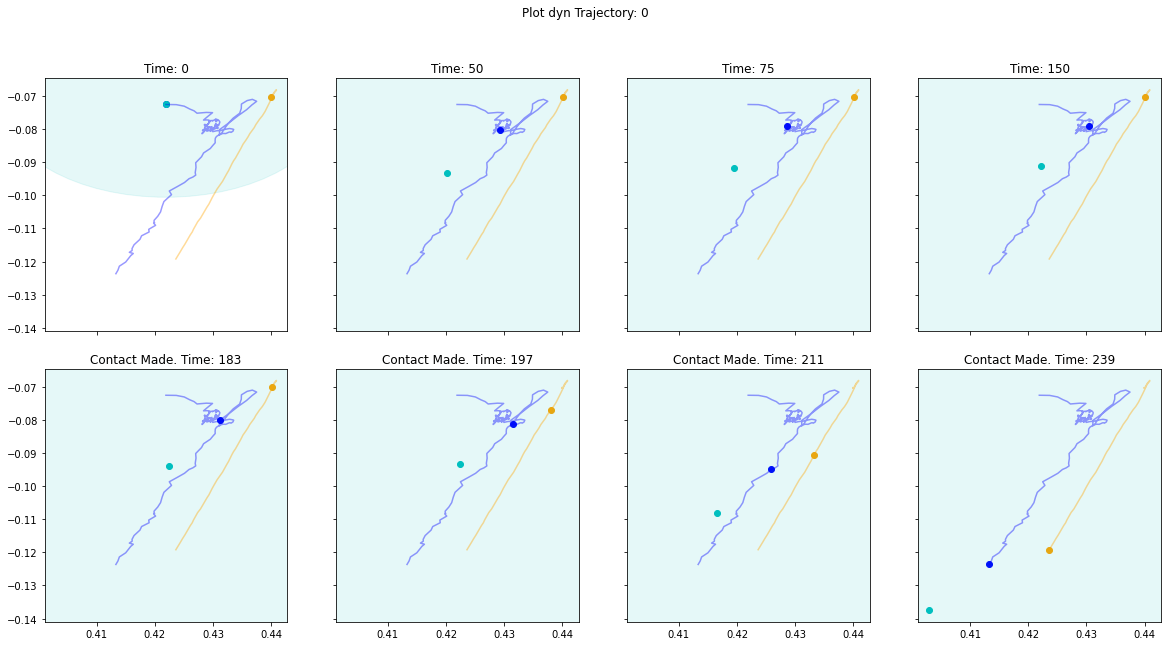

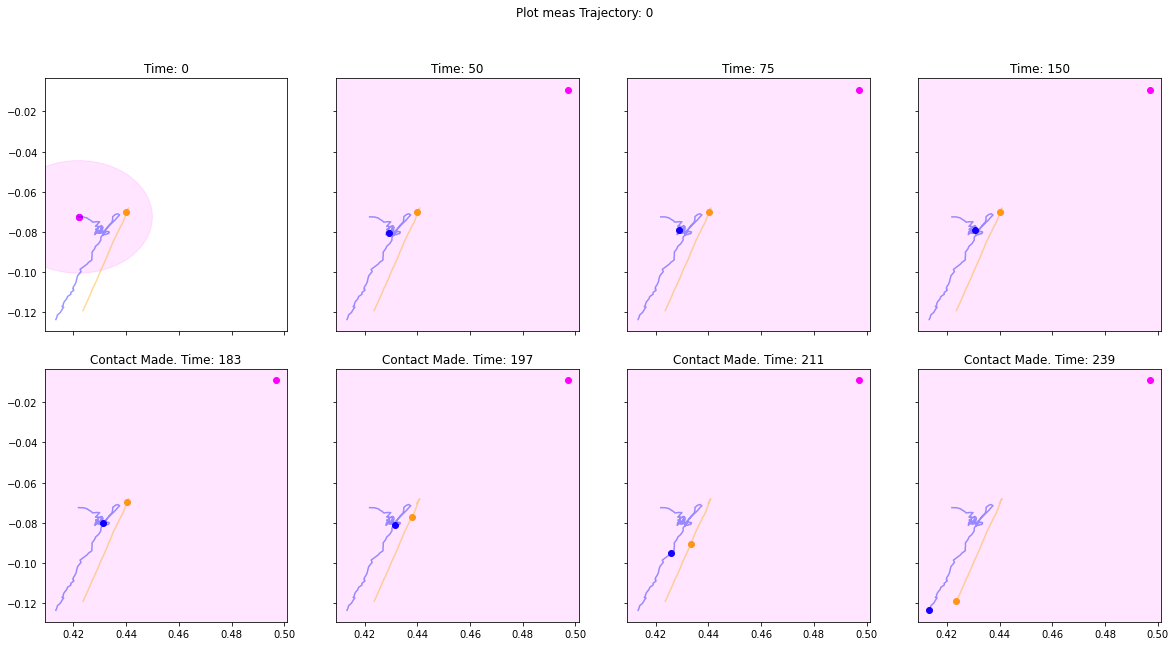

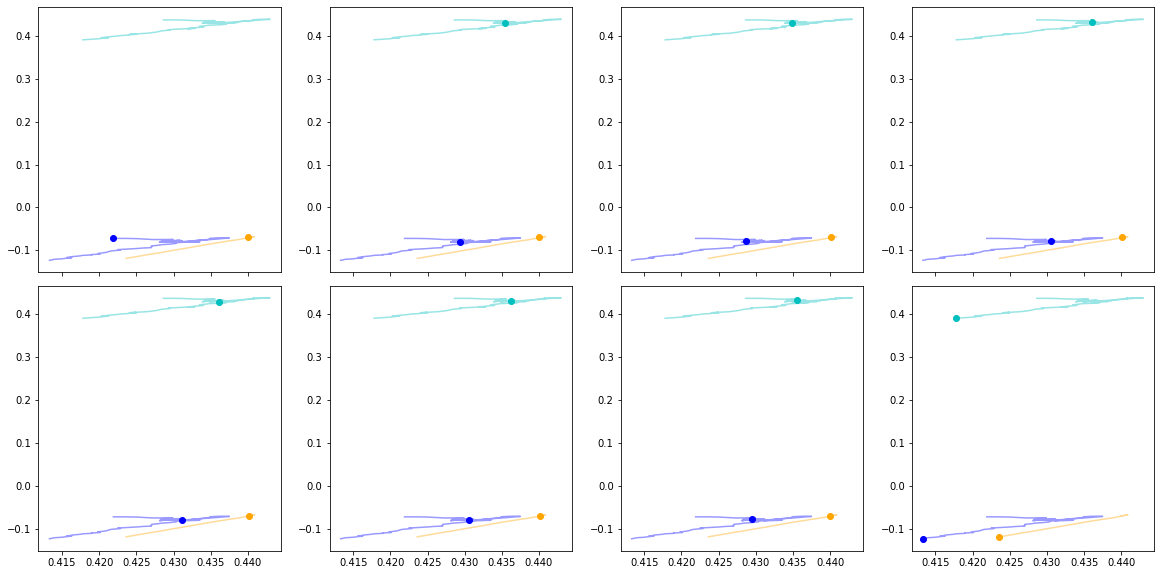

In [161]:
i=0
# eval_full_rollout(results, trajectories =[i], plot='all')
eval_full_rollout(results, trajectories =[i],plot='dyn')
eval_full_rollout(results, trajectories =[i],plot='meas')
plot_jacobian(results, trajectories=[i])

In [17]:
name = "ekfmse_measmse_fixed"
predicted_states, actual_states, predicted_sigmas, contact_states = evaluations.ekf_eval_experiment(name, load_checkpoint="phase_3_e2e")
print("Sigma average: ", np.mean(np.mean(predicted_sigmas,0), 0))
rmse_x = np.sqrt(np.mean(
    (predicted_states[:, start_time:, 0] - actual_states[:, start_time:, 0]) ** 2))

rmse_y = np.sqrt(np.mean(
    (predicted_states[:, start_time:, 1] - actual_states[:, start_time:, 1]) ** 2))

print("rsme x: \n{} \n y:\n{}".format(rmse_x, rmse_y))


[buddy-ekfmse_measmse_fixed] Using device: cuda
[buddy-ekfmse_measmse_fixed] Loaded metadata: {'batch': 128, 'ekf_loss': 'mse', 'epochs': 25, 'hidden_units': 128, 'image_blackout_ratio': 0.0, 'init state noise': 0.2, 'learnable_Q': False, 'learnable_Q_dynamics': False, 'measurement_loss': 'mse', 'obs_only': True, 'omnipush dataset': False, 'pretrain epochs': 5, 'sequential_image_rate': 1, 'set_r': None, 'start training from': 'ekf', 'start_timestep': 0, 'use_haptics': True, 'use_mass': False, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-ekfmse_measmse_fixed] Available checkpoint labels: ['0000000000105125', '0000000000105908', '0000000000106721', '0000000000107592', '0000000000108075', 'phase_0_dynamics_pretrain', 'phase_2_measurement_pretrain', 'phase_3_e2e']
[TrajectoriesFile-...le_push_1000.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_1000.hdf5" (mode r)>
[TrajectoriesFile-...le_push_1000.hdf5] Existing trajectory count: 1000
[Trajector

ValueError: too many values to unpack (expected 4)

183
14


/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


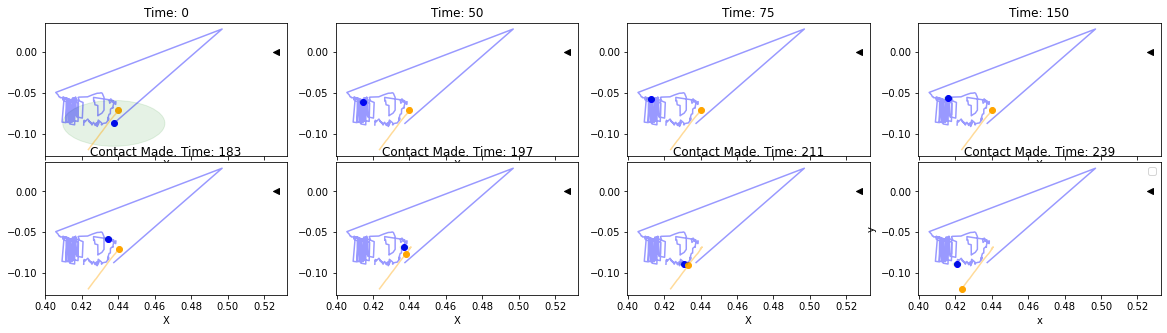

/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


[[ 1.4092932e-06 -1.1274409e-08]
 [-1.1274409e-08  1.3626494e-06]]
176
15


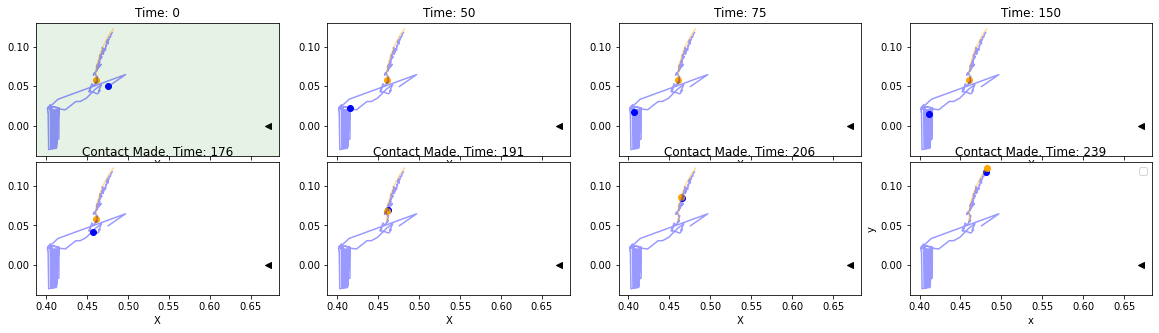

[[ 1.6752133e-04 -7.1246613e-09]
 [-7.1246613e-09  1.6748208e-04]]


In [11]:
for i in range(2):
    eval_2d_rollout(predicted_states[i], actual_states[i], predicted_sigmas[i], contact_states[i])

#     plot_kf_traj(predicted_states[i], actual_states[i], predicted_sigmas[i])
    print(np.mean(predicted_sigmas[i], 0))

In [15]:
name = "ekfnll_measnll_Q_fixed"
test = evaluations.ekf_eval_experiment(name, 
                    load_checkpoint="phase_2_measurement_pretrain")
print("Sigma average: ", np.mean(np.mean(predicted_sigmas,0), 0))


[buddy-ekfnll_measnll_Q_fixed] Using device: cuda
[buddy-ekfnll_measnll_Q_fixed] Loaded metadata: {'batch': 128, 'ekf_loss': 'nll', 'epochs': 25, 'hidden_units': 128, 'image_blackout_ratio': 0.0, 'init state noise': 0.2, 'learnable_Q': True, 'learnable_Q_dynamics': False, 'measurement_loss': 'nll', 'obs_only': True, 'omnipush dataset': False, 'pretrain epochs': 5, 'sequential_image_rate': 1, 'set_r': None, 'start training from': 'ekf', 'start_timestep': 0, 'use_haptics': True, 'use_mass': False, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-ekfnll_measnll_Q_fixed] Available checkpoint labels: ['0000000000048875', '0000000000049619', '0000000000050436', '0000000000051142', '0000000000051825', 'phase_0_dynamics_pretrain', 'phase_2_measurement_pretrain', 'phase_3_e2e']
[TrajectoriesFile-...le_push_1000.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_1000.hdf5" (mode r)>
[TrajectoriesFile-...le_push_1000.hdf5] Existing trajectory count: 1000
[Traj


Sigma average:  [[1.6731714e-04 1.6339403e-08]
 [1.6339403e-08 1.6582628e-04]]


/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


183
14


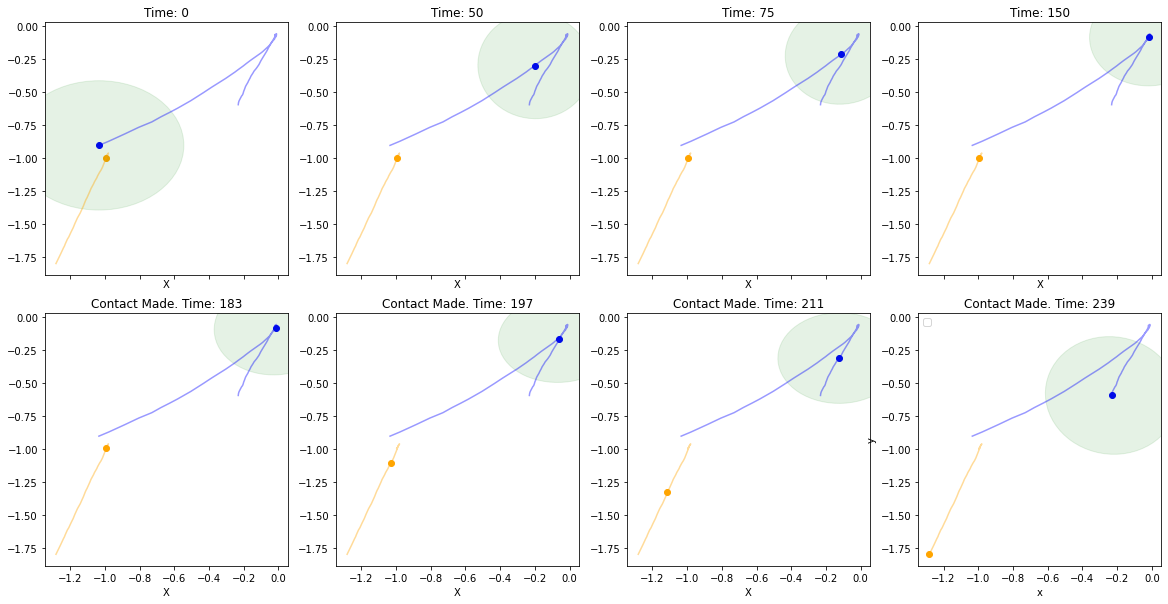

/scr-ssd/miniconda3/envs/filter/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
No handles with labels found to put in legend.


[[0.0203166  0.00031416]
 [0.00031416 0.024533  ]]
176
15


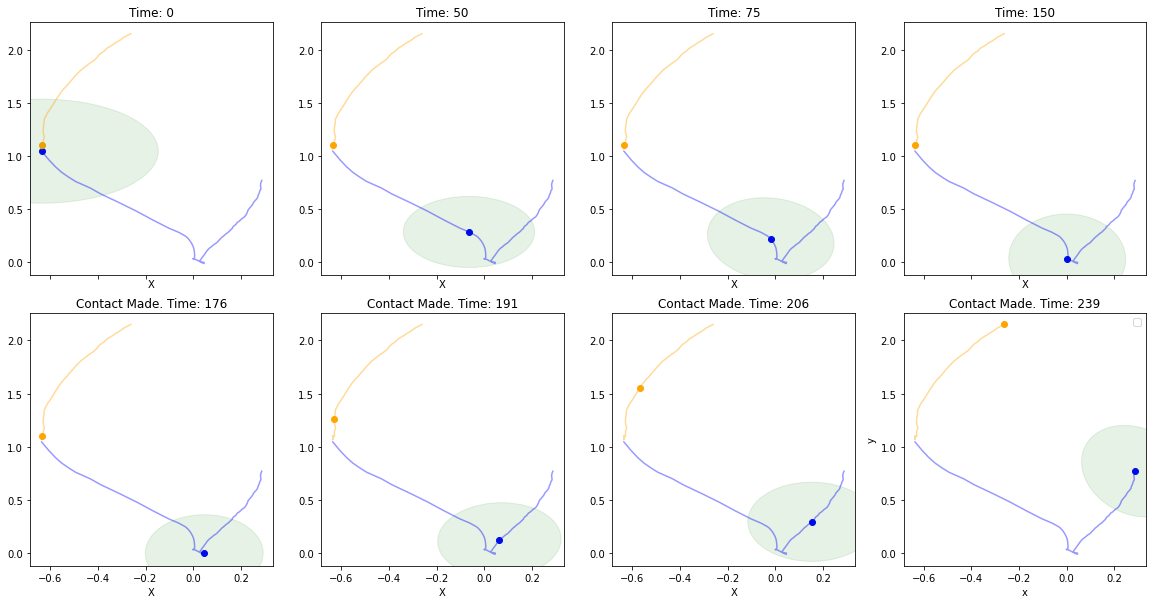

[[ 0.01262626 -0.00065797]
 [-0.00065797  0.02628287]]


In [137]:
for i in range(2):
    eval_2d_rollout(predicted_states[i], actual_states[i], predicted_sigmas[i], contact_states[i])

#     plot_kf_traj(predicted_states[i], actual_states[i], predicted_sigmas[i])
    print(np.mean(predicted_sigmas[i], 0))